# Importing

In [1]:
import numba 
from numba import jit, prange
import numpy as np
import cmath
import math
import numpy
from sympy.matrices import Matrix
from sympy.abc import f
import sympy as sp
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve
from sympy import simplify

import itertools
import emcee
import corner
# import scienceplots
# plt.style.use(['science','ieee','no-latex'])

from multiprocessing import Pool, cpu_count
import time
import os


import os
import PyPDF2
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image, Paragraph, Spacer
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from datetime import datetime
import arviz as az

actual_values = np.array(  [650,650,650,650,650,650,650,650])


# Assisting Functions

### Function to create the abcd matrix as a unit cell

In [2]:
def db_linear(x):
    return 10**(x/20)

In [3]:
def linear_db(x):
    return 20*math.log10(x) 

In [4]:
def unitcell(z_alpha, z_beta, z_gamma, chooseodd, invert): #if invert is True - the unit cell is flipped about vertical line of synmetry   
    bl_uc = (pi * sp.sqrt(eps_r) * f) / (8 * f_res)
    
    #alpha component of unit cell, always a TL
    abcd_tl_alpha = Matrix([[sp.cos(bl_uc), (sp.I) * z_alpha  * sp.sin(bl_uc)],
                      [((sp.I) * sp.sin(bl_uc))/z_alpha, sp.cos(bl_uc)]])  
    #beta component of unit cell, which is always stub, hence can be even or odd
    if chooseodd:
        abcd_stub_beta = Matrix([[1, 0],
                                 [(-sp.I)/(z_beta*sp.tan(bl_uc)), 1]])
    else:
        abcd_stub_beta = Matrix([[1, 0],
                                 [(sp.I * sp.tan(bl_uc))/z_beta, 1]])
    
    #gamma component of unit cell, always a TL
    abcd_tl_gamma = Matrix([[sp.cos(bl_uc), (sp.I) * z_gamma  * sp.sin(bl_uc)],
                  [((sp.I) * sp.sin(bl_uc))/z_gamma, sp.cos(bl_uc)]]) 
    
    #helpful argument while joining two unit cells into a square
    if invert:
        abcd = (abcd_tl_gamma * abcd_stub_beta) * abcd_tl_alpha
    else:
        abcd = (abcd_tl_alpha * abcd_stub_beta) * abcd_tl_gamma
    #print(simplify(abcd))
    #print('\n\n')
    return (abcd)

### Remove outlier with IQR Tukey

In [5]:
# Function to filter outliers based on IQR
def remove_outliers_flat(samples):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(samples, 25, axis=0)
    Q3 = np.percentile(samples, 75, axis=0)
    IQR = Q3 - Q1
    # Define the bounds for filtering
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Create a mask for samples that are within the bounds
    mask = np.all((samples >= lower_bound) & (samples <= upper_bound), axis=1)
    # Return the filtered samples
    return samples[mask]

# Function to filter outliers dimension-wise based on IQR
def remove_outliers(samples):
    # Get the shape of the original samples
    n_steps, n_walkers, n_dims = samples.shape
    
    # Initialize a list to collect valid samples
    filtered_samples_list = []
    
    # Create a mask for valid indices
    overall_mask = np.ones((n_steps, n_walkers), dtype=bool)
    
    for dim in range(n_dims):
        # Flatten the samples for the current dimension
        current_dim_samples = samples[:, :, dim].flatten()
        
        # Calculate Q1 and Q3 for the current dimension
        Q1 = np.percentile(current_dim_samples, 25)
        Q3 = np.percentile(current_dim_samples, 75)
        IQR = Q3 - Q1
        
        # Define the bounds for filtering
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR
        
        # Create a mask for valid samples in the current dimension
        dim_mask = (current_dim_samples >= lower_bound) & (current_dim_samples <= upper_bound)
        
        # Reshape the mask to match the original samples' shape
        dim_mask_reshaped = dim_mask.reshape(n_steps, n_walkers)
        
        # Update the overall mask
        overall_mask &= dim_mask_reshaped

    # Collect valid samples based on the overall mask
    for step in range(n_steps):
        for walker in range(n_walkers):
            if overall_mask[step, walker]:
                filtered_samples_list.append(samples[step, walker])

    # Convert the list to a NumPy array and reshape
    filtered_samples = np.array(filtered_samples_list)

    # Reshape to (n_filtered_samples, n_walkers, n_dims)
    n_filtered_samples = filtered_samples.shape[0] // n_walkers
    filtered_samples = filtered_samples[:n_filtered_samples * n_walkers].reshape(n_filtered_samples, n_walkers, n_dims)

    return filtered_samples

### QHDC Creater and plotter

In [6]:
def qhdc_creater_plotter(derived_imp):
    #input
    eps_r = 4.0
    f_res = 25 * pow(10, 9)  #GHz
    z_0 = 50
    z_line = z_0/math.sqrt(2)
    pi = math.pi
    
    #plot ===============================================================================
    
    freq_Hz = np.linspace(1 * pow(10, 9), 50 * pow(10, 9), 1000)
    # Convert frequency values from Hz to GHz
    freq_GHz = freq_Hz / pow(10, 9)
    
    s11_plot_dB_pre = []
    s21_plot_dB_pre = []
    s31_plot_dB_pre = []
    s41_plot_dB_pre = []

    for f_test in freq_Hz:
        s11_plot_dB_pre.append(get_s11eq(*np.append([f_test, 50], derived_imp)))
        s21_plot_dB_pre.append(get_s21eq(*np.append([f_test, 50], derived_imp)))
        s31_plot_dB_pre.append(get_s31eq(*np.append([f_test, 50], derived_imp)))
        s41_plot_dB_pre.append(get_s41eq(*np.append([f_test, 50], derived_imp)))

    s11_plot_dB = 20 * np.log10(np.abs(s11_plot_dB_pre))
    s21_plot_dB = 20 * np.log10(np.abs(s21_plot_dB_pre))
    s31_plot_dB = 20 * np.log10(np.abs(s31_plot_dB_pre))
    s41_plot_dB = 20 * np.log10(np.abs(s41_plot_dB_pre))
    
        
    # Plot the function
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(freq_GHz, s11_plot_dB, label='S11')
    ax1.plot(freq_GHz, s21_plot_dB, label='S21')
    ax1.plot(freq_GHz, s31_plot_dB, label='S31')
    ax1.plot(freq_GHz, s41_plot_dB, label='S41')

    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('S Parameter (dB)')
    #ax1.set_title('S Parameters Plot (dB)')
    ax1.grid(True)

    # Print the frequency values
    print(f"Center: {f_res / 1e9:.2f} GHz")

    # Find indices where the absolute difference between s11_plot_dB and -10 is minimum
    closest_to_minus_10_indices = np.argsort(np.abs(np.array(s11_plot_dB) + 20))[:2]

    # Ensure there are two occurrences
    if len(closest_to_minus_10_indices) == 2:
        index_1, index_2 = closest_to_minus_10_indices
        f_cut_1 = round(freq_GHz[index_1], 1)
        f_cut_2 = round(freq_GHz[index_2], 1)

        bw = round(np.abs(f_cut_2 - f_cut_1), 1)
        bw_frac = round(bw / (f_res / 1e9), 3)
        print(f'Normal: {f_cut_1} GHz - {f_cut_2} GHz, BW: {bw} GHz ({bw_frac})')
    else:
        print("There are not enough occurrences with values closest to -10.")

    ax1.axvline(x=freq_GHz[index_1], color='m', linestyle='--', linewidth=0.6)
    ax1.axvline(x=freq_GHz[index_2], color='m', linestyle='--', linewidth=0.6)
    ax1.axhline(y=-3, color='y', linestyle='--', linewidth=0.6)

    ax1.legend(title='Lines', loc="best")
    ax1.set_ylim(-40, 0)

    # Create the second figure and plot
    fig2, ax2 = plt.subplots(figsize=(8, 2))
    s21_s31_diff_db = (s21_plot_dB - s31_plot_dB)

    ax2.plot(freq_GHz, s21_s31_diff_db, label='S21-S31')
    ax2.set_xlabel('Frequency (GHz)')
    ax2.set_ylabel('S21 - S31 (dB)')

    # Find the index of the peak in s21_s31_diff_db
    peak_index = np.argmax(s21_s31_diff_db)

    # Find all indices where the value crosses -1 or is -1
    crossing_indices = []
    for i in range(1, len(s21_s31_diff_db)):
        if (s21_s31_diff_db[i - 1] < -1.8 <= s21_s31_diff_db[i]) or (s21_s31_diff_db[i - 1] >= -1.8 > s21_s31_diff_db[i]):
            crossing_indices.append(i)

    # Include indices where the value is exactly -1
    exact_crossing_indices = [i for i, value in enumerate(s21_s31_diff_db) if value == -1.8]
    crossing_indices.extend(exact_crossing_indices)
    crossing_indices = sorted(set(crossing_indices))  # Remove duplicates and sort
    
    temp_freq_list = []
    # Plot vertical lines and labels at crossing points
    for index in crossing_indices:
        ax2.axvline(x=freq_GHz[index], color='m', linestyle='--', linewidth=0.6)
        ax2.text(freq_GHz[index], 0.8, f'{freq_GHz[index]:.1f} GHz', color='m', fontsize=14, ha='center', va='bottom')
        temp_freq_list.append(freq_GHz[index])
    
    temp_freq_list = sorted(temp_freq_list)
    diff_bw_s21_s31 = round((temp_freq_list[2] - temp_freq_list[1]) / (f_res / 1e9), 3)
    
    # Draw horizontal line at -1
    ax2.axhline(y=-1.8, color='y', linestyle='--', linewidth=0.6, label = 'diff = 1.8/-1.8')
    ax2.axhline(y=1.8, color='y', linestyle='--', linewidth=0.6)
    #ax2.axhline(y=s21_s31_diff_db[peak_index], color='y', linestyle='--', linewidth=0.6, label = 'peak diff')
    
    # Set title and grid
    print(f'Diff: S21 - S31 ({diff_bw_s21_s31}) offset {round(s21_s31_diff_db[peak_index], 2)} dB')
    ax2.grid(True)
    ax2.legend(title='Lines', loc="best")
    
    fig3, ax3 = plt.subplots(figsize=(8, 2))
    ax3.set_xlabel('Frequency (GHz)')
    ax3.set_ylabel('S21/S31+3 (dB)')
    ax3.plot(freq_GHz, np.abs(s21_plot_dB+3), label='S21-0.5')
    ax3.plot(freq_GHz, np.abs(s31_plot_dB+3), label='S31-0.5')
    ax3.grid(True)
    ax3.legend(title='Lines', loc="best")
    ax3.axhline(y=1, color='y', linestyle='--', linewidth=0.6, label = 'diff = 1')
    ax3.set_ylim(0,2)
    # Return the Figure object
    return fig1, fig2

In [7]:
def create_symbols(num_sections):
    symbols_list_v = {}
    symbols_list_h = {}
    
    for i in range(1, ((num_sections + 2) // 2) + 1):
        symbols_list_v[f'zv_{i}'] = sp.symbols(f'zv_{i}')
        
    for i in range(1, ((num_sections + 1) // 2) + 1):
        symbols_list_h[f'zh_{i}'] = sp.symbols(f'zh_{i}')
        
    # Combine the values from both dictionaries into a single list
    symbols_list = [x for x in itertools.chain(*itertools.zip_longest(symbols_list_v.values(), symbols_list_h.values())) if x is not None]

    return symbols_list

# Numba Assistance functions, precompile

### Get a,b,c,d even and odd

In [8]:
#input
eps_r = 4.0
f_res = 25 * pow(10, 9)  #GHz
z_0 = 50
z_line = z_0/math.sqrt(2)
global s21_const
s21_const = 1/math.sqrt(2)
pi = math.pi

f, z0 = sp.symbols('f z0')

# Input: number of sections from the user
num_sections = int(input("Enter the number of sections: "))

# Generate the symbols
global symbols_list
symbols_list = create_symbols(num_sections)
print(symbols_list)

# chooseodd  invert
imp_list = [z0] + symbols_list + symbols_list[::-1][1:] + [z0] # n = 3

for i in range(0,len(imp_list)-1,2):
    
    #print(imp_list[i], imp_list[i+1], imp_list[i+2])
    if i == 0:
        abcd_even = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
        abcd_odd = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)
    else:
        abcd_even = abcd_even * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
        abcd_odd = abcd_odd * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)



a_e = abcd_even.row(0)[0]
b_e = abcd_even.row(0)[1]
c_e = abcd_even.row(1)[0]
d_e = abcd_even.row(1)[1]

a_o = abcd_odd.row(0)[0]
b_o = abcd_odd.row(0)[1]
c_o = abcd_odd.row(1)[0]
d_o = abcd_odd.row(1)[1]

Enter the number of sections:  7


[zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4]


### Make strings compatible with Numpy

In [9]:
start = time.time()
a_e_numba = str(a_e).replace('cos(', 'np.cos(')
a_e_numba = a_e_numba.replace('sin(', 'np.sin(')
a_e_numba = a_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 1 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
a_o_numba = str(a_o).replace('cos(', 'np.cos(')
a_o_numba = a_o_numba.replace('sin(', 'np.sin(')
a_o_numba = a_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 2 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
b_e_numba = str(b_e).replace('cos(', 'np.cos(')
b_e_numba = b_e_numba.replace('sin(', 'np.sin(')
b_e_numba = b_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 3 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
b_o_numba = str(b_o).replace('cos(', 'np.cos(')
b_o_numba = b_o_numba.replace('sin(', 'np.sin(')
b_o_numba = b_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 4 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
c_e_numba = str(c_e).replace('cos(', 'np.cos(')
c_e_numba = c_e_numba.replace('sin(', 'np.sin(')
c_e_numba = c_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 5 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
c_o_numba = str(c_o).replace('cos(', 'np.cos(')
c_o_numba = c_o_numba.replace('sin(', 'np.sin(')
c_o_numba = c_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 6 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
d_e_numba = str(d_e).replace('cos(', 'np.cos(')
d_e_numba = d_e_numba.replace('sin(', 'np.sin(')
d_e_numba = d_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 7 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
d_o_numba = str(d_o).replace('cos(', 'np.cos(')
d_o_numba = d_o_numba.replace('sin(', 'np.sin(')
d_o_numba = d_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 8 string loaded in ' + str(round(end-start,4)) + ' s')

Equation 1 string loaded in 0.4781 s
Equation 2 string loaded in 0.3318 s
Equation 3 string loaded in 0.3238 s
Equation 4 string loaded in 0.3233 s
Equation 5 string loaded in 0.3377 s
Equation 6 string loaded in 0.3442 s
Equation 7 string loaded in 0.3363 s
Equation 8 string loaded in 0.3387 s


### Numba functions of a,b,c,d

In [10]:
@jit(nopython=True, cache=True)
def get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [11]:
@jit(nopython=True, cache=True)
def get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [12]:
@jit(nopython=True, cache=True)
def get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

In [13]:
@jit(nopython=True, cache=True)
def get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

In [14]:
@jit(nopython=True, cache=True)
def get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [15]:
@jit(nopython=True, cache=True)
def get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [16]:
@jit(nopython=True, cache=True)
def get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(-zh_4*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(-zh_3*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_4 + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_3 + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

In [17]:
@jit(nopython=True, cache=True)
def get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    I = 1j
    return ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*((zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_3*np.sin(3.14159265358979e-11*f)**2/zh_2) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*((zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_4*np.sin(3.14159265358979e-11*f)**2/zh_3) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_2*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(-zh_3*np.sin(3.14159265358979e-11*f)**2/zh_4 + (zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_4))*(I*zh_3*(zh_4*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_4*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(-zh_2*np.sin(3.14159265358979e-11*f)**2/zh_3 + (zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_3))*(I*zh_3*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_4*(zh_3*np.sin(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_3*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_4*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_3*(-I*np.cos(3.14159265358979e-11*f)/(zv_4*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_4)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_3*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_3)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

#### Individual Numba Precompile

In [18]:
start = time.time()
20 * np.log10(np.abs(get_a_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_a_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')


def get_s11eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    
    gamma_e = (a_e + (b_e/z_0) - (c_e*z_0) - d_e ) / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    gamma_o = (a_o + (b_o/z_0) - (c_o*z_0) - d_o ) / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s11 = (gamma_e + gamma_o) / 2
    
    return s11

def get_s21eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    
    t_e = 2 / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    t_o = 2 / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s21 = (t_e + t_o) / 2
    
    return s21

def get_s31eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    
    t_e = 2 / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    t_o = 2 / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s31 = (t_e - t_o) / 2
    
    return s31

def get_s41eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2, zv_3, zh_3, zv_4, zh_4)
    
    gamma_e = (a_e + (b_e/z_0) - (c_e*z_0) - d_e ) / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    gamma_o = (a_o + (b_o/z_0) - (c_o*z_0) - d_o ) / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s41 = (gamma_e - gamma_o) / 2
    
    return s41

Equation string loaded in 0.2534 s
Equation string loaded in 0.0638 s
Equation string loaded in 0.0474 s
Equation string loaded in 0.0779 s
Equation string loaded in 0.1026 s
Equation string loaded in 0.0743 s
Equation string loaded in 0.0572 s
Equation string loaded in 0.0436 s


### Test code

In [19]:
start = time.time()
20 * np.log10(np.abs(get_a_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_a_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s


# Markov chain monte carlo optimisation

### MCMC Functions

In [45]:
def model_get(x, freq, s):    
    returnlist = []
    for f_ in freq:        
        
        if s == 's11':      
            ans = float(np.abs(get_s11eq(*np.append([f_, 50], x))))   
        elif s == 's21':     
            ans = float(np.abs(get_s21eq(*np.append([f_, 50], x))))   
        elif s == 's31':   
            ans = float(np.abs(get_s31eq(*np.append([f_, 50], x))))   
        elif s == 's41':      
            ans = float(np.abs(get_s41eq(*np.append([f_, 50], x))))   
        else:
            ans = 0       
        returnlist.append(ans)    
        
    return (np.array(returnlist))
    
def lnlike(x, freq, s_list, y_, yerr_):
    ln_alpha = []
    
    for i in range(len(s_list)):
        
        y_i = np.array([y_[i]]*len(freq))
        yerr_i = np.array([yerr_[i]]*len(freq))
               
        model = model_get(x, freq, s_list[i])
        
        inv_sigma2 = 1/(yerr_i**2)
        ln_alpha = np.append(ln_alpha, -1*(np.sum((y_i-model)**2*(inv_sigma2/2) - np.log(inv_sigma2/math.sqrt(np.pi*2)))))
    return np.sum(ln_alpha)

# def lnprior(x, f_, bounds_):
#     qi = []
    
#     for freq in f_:
        
#         qi.append(
#             float(np.abs((get_s11eq(*np.append([freq, 50], x )))**2))  +
#             float(np.abs((get_s21eq(*np.append([freq, 50], x )))**2))  +
#             float(np.abs((get_s31eq(*np.append([freq, 50], x )))**2))  +
#             float(np.abs((get_s41eq(*np.append([freq, 50], x )))**2)) 
#         )
    
#     # Constructing conditions
#     conditions_met = 1
#     conditions_met &= all((bounds_[i][0] < x[i] < bounds_[i][1]) for i in range(len(x)))
#     conditions_met &= all(np.abs(q - 1) < 0.001 for q in qi)
#     #print(conditions_met)
    
#     return 0.0 if conditions_met else -np.inf


def lnprior(x, f_, bounds_, mu_, sigma_):
    # List to store the computed qi values
    qi = []
    
    # Calculate qi for each frequency
    for freq in f_:
        qi.append(
            float(np.abs((get_s11eq(*np.append([freq, 50], x )))**2))  +
            float(np.abs((get_s21eq(*np.append([freq, 50], x )))**2))  +
            float(np.abs((get_s31eq(*np.append([freq, 50], x )))**2))  +
            float(np.abs((get_s41eq(*np.append([freq, 50], x )))**2)) 
        )
    
    # Check if parameters are within bounds (still the same as before)
    conditions_met = 1
    conditions_met &= all((bounds_[i][0] < x[i] < bounds_[i][1]) for i in range(len(x)))
    
    # Check if qi values are close to 1 (still the same as before)
    conditions_met &= all(np.abs(q - 1) < 0.001 for q in qi)
    
    # If any condition is violated, return -inf
    if not conditions_met:
        return -np.inf

    # Applying the Gaussian prior for each parameter x[i]
    gaussian_prior = 0.0
    for i in range(len(x)):
        # For each parameter, apply the Gaussian prior
        if bounds_[i][0] < x[i] < bounds_[i][1]:  # Ensure within bounds
            # Gaussian prior: P(x_i) = exp(-0.5 * ((x_i - mu_i) / sigma_i)^2)
            gaussian_prior += -0.5 * ((x[i] - mu_[i]) / sigma_[i])**2 - 0.5 * np.log(2 * np.pi * sigma_[i]**2)
        else:
            return -np.inf  # Reject if outside bounds
        
    return gaussian_prior

def lnpost(x, freq, s_list_solve, y_, yerr_, bounds_):    
    
    lnp = lnprior(x, freq, bounds_, [400,400,400,400,400,400,400,400],[200,200,200,200,200,200,200,200])    
    if not np.isfinite(lnp):
        return -np.inf    
    templike = lnlike(x, freq, s_list_solve, y_, yerr_)    
    temp = lnp + templike   
    return temp

# Multiprocessing MCMC

### Inputs

#### Seven Section inputs

In [70]:
actual_values = np.array(  [650,650,650,650,650,650,650,650])
guess =                    [350,350,350,350,350,350,350,350]
bounds =                   [[0,700],[0,700],[0,700],[0,700],[0,700],[0,700],[0,700],[0,700]]

#==================================================
s11_actual = 0.01 + 0.01j    #  s41_actual is the same
s21_actual = 0 - 0.707j
s31_actual = -0.707 + 0.j

s11s41_ab = 1e-6 #np.abs(s11_actual)
s11s41_ph = np.angle(s11_actual)

s21_ab = np.abs(s21_actual)
s21_ph = np.angle(s21_actual)

s31_ab = np.abs(s31_actual)
s31_ph = np.angle(s31_actual)

s21_s31_db = 0.001
#==================================================
y = np.array([

[s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab],    
[s21_ab,     s21_ab,     s21_ab,     s21_ab,     s21_ab,     s21_ab,     s21_ab],
[s31_ab,     s31_ab,     s31_ab,     s31_ab,     s31_ab,     s31_ab,     s31_ab],
[s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab,  s11s41_ab]

])
print(y)
# Multiplier array as a NumPy array

y_err_tol_matrix = np.array([
    
[10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7],
[10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7],
[10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7],
[10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7]
    
])

freq_solve = [12e9, 15e9, 20e9, 25e9, 30e9, 35e9, 38e9] #freq points on which to solve
ndim = 8  # Number of parameters
s_list_solve = ['s11', 's21', 's31', 's41']  #, 's21-s31'] # which Sij to be included in solving
nwalkers = 350  # Number of walkers
nsteps = 30000  # Number of steps
pert = 0.001 #  Add a small random offset to the initial guess to initialize the walkers
burn_in = 10000  # Adjust based on your specific case
thin = 5
noofcores = 30

[[1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06]
 [7.07e-01 7.07e-01 7.07e-01 7.07e-01 7.07e-01 7.07e-01 7.07e-01]
 [7.07e-01 7.07e-01 7.07e-01 7.07e-01 7.07e-01 7.07e-01 7.07e-01]
 [1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06]]


In [23]:
actual_values = np.array(  [650,650,650,650,650,650,650,650])
guess =                    [650,650,650,650,650,650,650,650]
bounds =                   [[0,900],[0,900],[0,900],[0,900],[0,900],[0,900],[0,900],[0,900]]

y =    np.array( [0.00001,      s21_const,      s21_const,      0.00001])

yerr = np.array([[0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-2,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4],
                 [s21_const*1e-4, s21_const*1e-4, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-4, s21_const*1e-4], 
                 [s21_const*1e-4, s21_const*1e-4, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-4, s21_const*1e-4], 
                 [0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-2,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4]])

freq_solve =     [10e9,           15e9,           20e9,           25e9,           30e9,           35e9,           40e9] #freq points on which to solve

ndim = 8  # Number of parameters

s_list_solve = ['s11', 's21', 's31', 's41'] # which Sij to be included in solving
nwalkers = 200  # Number of walkers
nsteps = 1000  # Number of steps
pert = 0.001 #  Add a small random offset to the initial guess to initialize the walkers

burn_in = 500  # Adjust based on your specific case
thin = 5
noofcores = 30

#### Nine Section inputs

In [30]:
actual_values = np.array(  [1000,      49,    1000,     49,    1000,    49,      650,     49,     650,     49])
guess =                    [1000,      49,    1000,     49,    1000,    49,      650,     49,     650,     49]
bounds =                   [[0,1001],[0,50],[0,1001], [0,50], [0,1001],[0,50], [0,700], [0,50], [0,700], [0,50]]
                    #       419.56    45.13   700.     41.56    700.    38.72   413.40  36.12    297.45   35.03
y =    np.array( [0.000001,      s21_const,      s21_const,      0.000001])

yerr = np.array([[0.00001*1e-6,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-6],
                 [s21_const*1e-4, s21_const*1e-4, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-4, s21_const*1e-4], 
                 [s21_const*1e-4, s21_const*1e-4, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-6, s21_const*1e-4, s21_const*1e-4], 
                 [0.00001*1e-6,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-4,   0.00001*1e-6]])

freq_solve =     [9e9,            12e9,           15e9,           20e9,           25e9,           30e9,           35e9,           38e9 ,          41e9] #freq points on which to solve
ndim = 10  # Number of parameters

s_list_solve = ['s11', 's21', 's31', 's41'] # which Sij to be included in solving
nwalkers = 300  # Number of walkers
nsteps = 1000  # Number of steps
pert = 1e-1 #  Add a small random offset to the initial guess to initialize the walkers

burn_in = 1000  # Adjust based on your specific case
thin = 5
noofcores = 32

#### Eleven Section inputs

In [24]:
actual_values = np.array(  [650,650,650,650,650,650,650,650,650,650])
guess =                    [650,650,650,650,650,650,650,650,650,650]
bounds =                   [[0,700],[0,700],[0,700],[0,700],[0,700],[0,700],[0,700],[0,700],[0,700],[0,700]]

y =    np.array([0.00001,      s21_const,      s21_const,      0.00001])
yerr = np.array([0.00001*1e-2, s21_const*1e-2, s21_const*1e-2, 0.00001*1e-2])

freq_solve = [10e9,15e9,20e9,25e9,30e9,35e9,40e9] #freq points on which to solve
ndim = 10  # Number of parameters

s_list_solve = ['s11', 's21', 's31', 's41'] # which Sij to be included in solving
nwalkers = 200  # Number of walkers
nsteps = 5000  # Number of steps
pert = 1e-1 #  Add a small random offset to the initial guess to initialize the walkers

burn_in = 2000  # Adjust based on your specific case
thin = 5
noofcores = 25

#### Run MCMC 

In [71]:
p0 = [guess + pert * np.random.randn(ndim) for i in range(nwalkers)]

start = time.time()
with Pool(processes=noofcores) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(freq_solve, s_list_solve, np.array(y), np.array(y_err_tol_matrix), bounds), pool = pool)    
    sampler.run_mcmc(p0, nsteps, progress=True) 
    
end = time.time() 
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|█████████████████████████████████████| 30000/30000 [30:45<00:00, 16.26it/s]


Multiprocessing took 1848.9 seconds


## Analysis of MCMC

#### Extracting output values by mcmc run

In [72]:
# Assuming 'sampler' is your emcee.EnsembleSampler object
samples_flat = sampler.get_chain(discard=burn_in, thin=thin, flat=True)  # Discard the burn-in samples and thin the chain
samples = sampler.get_chain(discard=burn_in, thin=thin, flat=False) 

#### Apply filters - Tukey IQR filter

In [73]:
# Filtering flat sample
filtered_samples_flat = remove_outliers_flat(samples_flat)
print(samples_flat.shape, filtered_samples_flat.shape)

# Filtering non-flat samples dimension wise
filtered_samples = remove_outliers(samples)
print(samples.shape, filtered_samples.shape)

(1400000, 8) (1233558, 8)
(4000, 350, 8) (3549, 350, 8)


### Mean, median, map estimate

#### w/o filter

In [74]:
# Calculate the mean of the posterior distributions
mean_values = np.mean(samples_flat, axis=0)
print("Mean values:", mean_values)

# Calculate the median of the posterior distributions
median_values = np.median(samples_flat, axis=0)
print("Median values:", median_values)

# Calculate the standard deviation of the posterior distributions
std_devs = np.std(samples_flat, axis=0)
print("Standard deviations:", std_devs)

# If you want to find the MAP estimate (the sample with the highest posterior probability)
# Note: This requires the log_prob_fn to be the posterior probability function
log_probs = sampler.get_log_prob(discard=burn_in, thin=thin, flat=True)
max_prob_index = np.argmax(log_probs)
map_estimate = samples_flat[max_prob_index]
print("MAP estimate:", map_estimate)

print("Actual values:", list(actual_values))

Mean values: [593.51822255  58.77767611 345.48740307  57.41117507 215.64659337
  57.36461035 150.03831967  53.43950433]
Median values: [627.30782592  46.28679322 370.37958083  39.75778893 215.28923932
  33.77535094 146.61302094  31.42549538]
Standard deviations: [112.23590505  45.57519572  77.79324014  58.30497886  39.66364352
  80.80058842  45.59679757  85.6718652 ]
MAP estimate: [627.30788943  46.28679226 370.37958729  39.75778624 215.28923088
  33.77534679 146.61301004  31.42549079]
Actual values: [650, 650, 650, 650, 650, 650, 650, 650]


#### w filter

In [75]:
# Calculate the mean of the posterior distributions
mean_values_f = np.mean(filtered_samples_flat, axis=0)
print("Mean values:", mean_values)

# Calculate the median of the posterior distributions
median_values_f = np.median(filtered_samples_flat, axis=0)
print("Median values:", median_values)

# Calculate the standard deviation of the posterior distributions
std_devs_f = np.std(filtered_samples_flat, axis=0)
print("Standard deviations:", std_devs)

# If you want to find the MAP estimate (the sample with the highest posterior probability)
# Note: This requires the log_prob_fn to be the posterior probability function
log_probs_f = sampler.get_log_prob(discard=burn_in, thin=thin, flat=True)
max_prob_index_f = np.argmax(log_probs_f)
map_estimate_f = filtered_samples_flat[max_prob_index_f]
print("MAP estimate:", map_estimate_f)

print("Actual values:", list(actual_values))

Mean values: [593.51822255  58.77767611 345.48740307  57.41117507 215.64659337
  57.36461035 150.03831967  53.43950433]
Median values: [627.30782592  46.28679322 370.37958083  39.75778893 215.28923932
  33.77535094 146.61302094  31.42549538]
Standard deviations: [112.23590505  45.57519572  77.79324014  58.30497886  39.66364352
  80.80058842  45.59679757  85.6718652 ]
MAP estimate: [627.30763467  46.28679644 370.3796759   39.7577934  215.28925968
  33.77535627 146.61307624  31.42550115]
Actual values: [650, 650, 650, 650, 650, 650, 650, 650]


### Parameter Time series

#### Whole chain without any burn in or thin

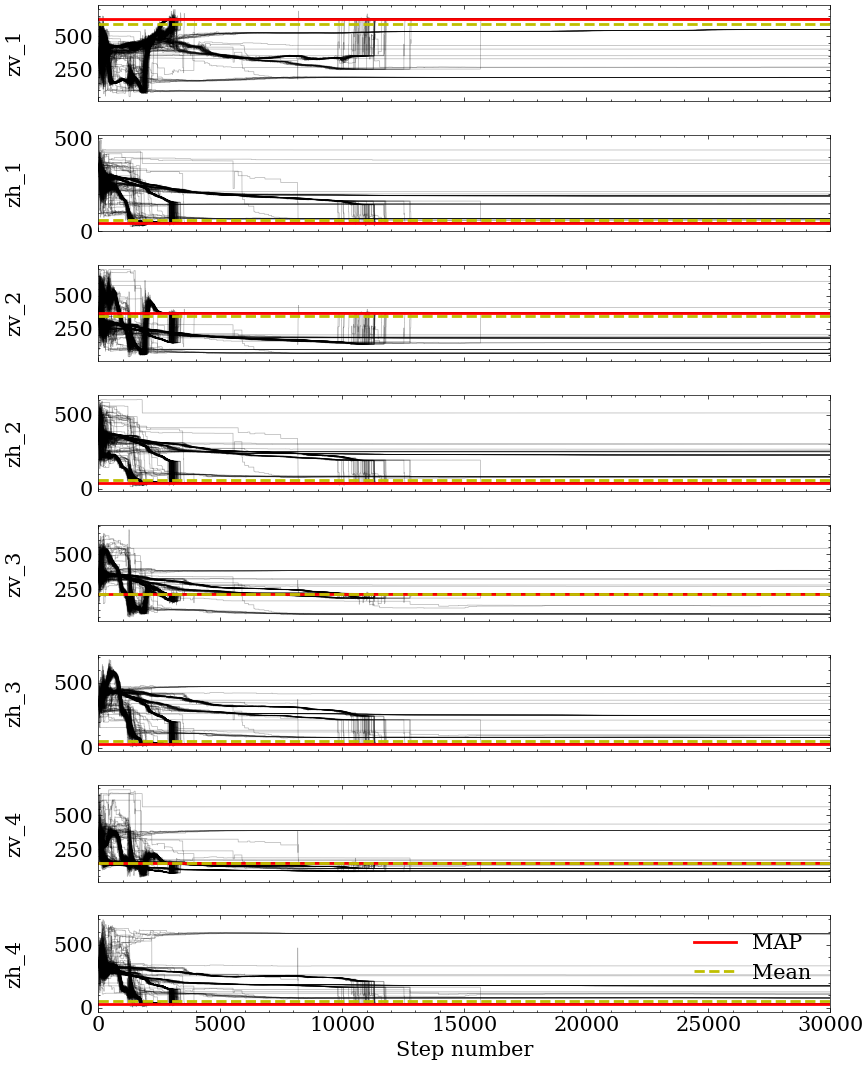

In [76]:
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline
# Set the style to 'science'
plt.style.use('science')

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Assuming sampler is your emcee.EnsembleSampler object
samples_whole = sampler.get_chain()

# Plot the traces of the parameters
fig_samples_all, axes = plt.subplots(ndim, figsize=(9, 11), sharex=True)
labels = symbols_list

fs = 15
# Set font properties with all sizes set to 25
plt.rcParams.update({
    'font.family': 'serif', 
    'font.serif': 'DejaVu Serif',  # Or 'Times New Roman' if installed
    'font.size': fs,                 # General font size
    'axes.titlesize': fs,           # Title size
    'axes.labelsize': fs,           # Axis label size
    'xtick.labelsize': fs,          # X-axis tick label size
    'ytick.labelsize': fs,          # Y-axis tick label size
    'legend.fontsize': fs            # Legend font size
})

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_whole[:, :, i], "k", alpha=0.3, linewidth=0.5)
    ax.set_xlim(0, len(samples_whole))  
    ax.set_ylabel(labels[i], fontsize=fs)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    # Add horizontal lines for actual values, MAP, and mean
    ax.axhline(y=map_estimate[i], color='r', linestyle='-', linewidth=2, label='MAP')
    ax.axhline(y=mean_values[i], color='y', linestyle='--', linewidth=2, label='Mean')

    # Increase tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Reduce the number of x-ticks
    xticks = ax.get_xticks()
    reduced_xticks = xticks[::len(xticks) // 4]  # Adjust this for desired number of ticks
    ax.set_xticks(reduced_xticks)

# Set xlabel for the last subplot
axes[-1].set_xlabel("Step number", fontsize=fs)
plt.legend(loc='best', fontsize=fs)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### w/o filter

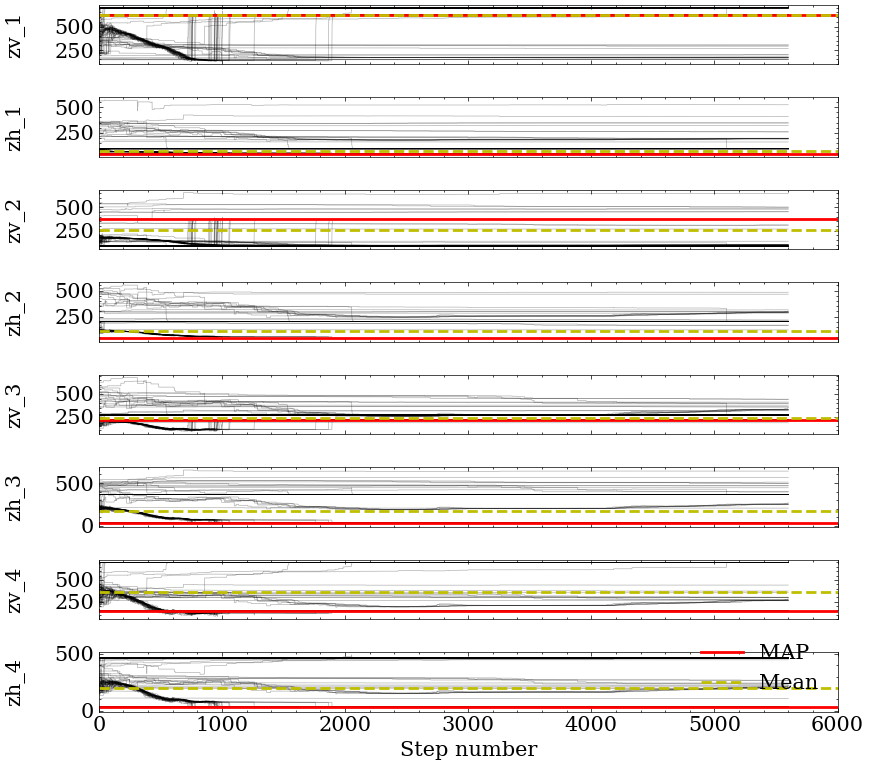

In [55]:
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline
# Set the style to 'science'
plt.style.use('science')

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Assuming sampler is your emcee.EnsembleSampler object
#samples_all = sampler.get_chain()

# Plot the traces of the parameters
fig_samples_all, axes = plt.subplots(ndim, figsize=(9, 8), sharex=True)
labels = symbols_list

fs = 15
# Set font properties with all sizes set to 25
plt.rcParams.update({
    'font.family': 'serif', 
    'font.serif': 'DejaVu Serif',  # Or 'Times New Roman' if installed
    'font.size': fs,                 # General font size
    'axes.titlesize': fs,           # Title size
    'axes.labelsize': fs,           # Axis label size
    'xtick.labelsize': fs,          # X-axis tick label size
    'ytick.labelsize': fs,          # Y-axis tick label size
    'legend.fontsize': fs            # Legend font size
})

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, linewidth=0.5)
    ax.set_xlim(0, len(samples))  
    ax.set_ylabel(labels[i], fontsize=fs)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    # Add horizontal lines for actual values, MAP, and mean
    ax.axhline(y=map_estimate[i], color='r', linestyle='-', linewidth=2, label='MAP')
    ax.axhline(y=mean_values[i], color='y', linestyle='--', linewidth=2, label='Mean')

    # Increase tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Reduce the number of x-ticks
    xticks = ax.get_xticks()
    reduced_xticks = xticks[::len(xticks) // 4]  # Adjust this for desired number of ticks
    ax.set_xticks(reduced_xticks)

# Set xlabel for the last subplot
axes[-1].set_xlabel("Step number", fontsize=fs)
plt.legend(loc='best', fontsize=fs)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### w filter

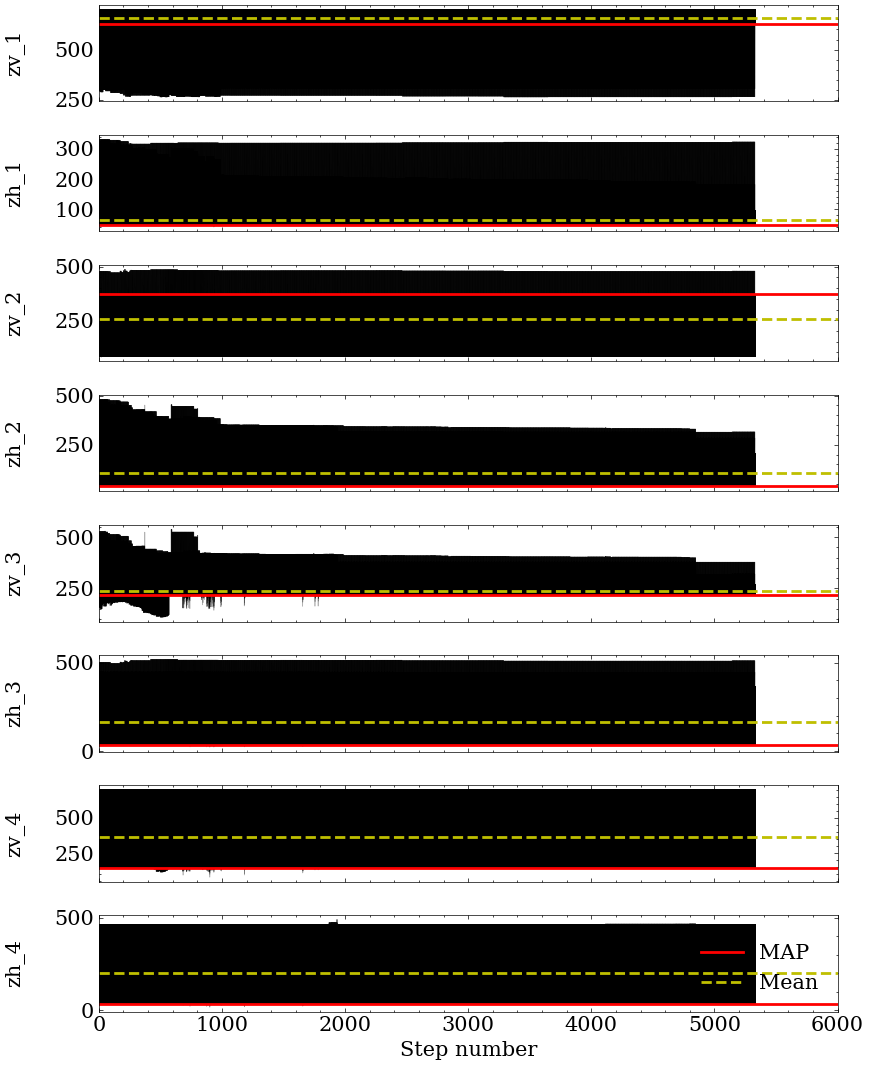

In [57]:
import matplotlib.pyplot as plt
import scienceplots

%matplotlib inline

# Set the style to 'science'
plt.style.use('science')

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Assuming sampler is your emcee.EnsembleSampler object
#samples_all = sampler.get_chain()

# Plot the traces of the parameters
fig_samples_all, axes = plt.subplots(ndim, figsize=(9, 11), sharex=True)
labels = symbols_list

fs = 15
# Set font properties with all sizes set to 25
plt.rcParams.update({
    'font.family': 'serif', 
    'font.serif': 'DejaVu Serif',  # Or 'Times New Roman' if installed
    'font.size': fs,                 # General font size
    'axes.titlesize': fs,           # Title size
    'axes.labelsize': fs,           # Axis label size
    'xtick.labelsize': fs,          # X-axis tick label size
    'ytick.labelsize': fs,          # Y-axis tick label size
    'legend.fontsize': fs            # Legend font size
})

for i in range(ndim):
    ax = axes[i]
    ax.plot(filtered_samples[:, :, i], "k", alpha=0.3, linewidth=0.5)
    ax.set_xlim(0, len(filtered_samples))  
    ax.set_ylabel(labels[i], fontsize=fs)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    # Add horizontal lines for actual values, MAP, and mean
    ax.axhline(y=map_estimate_f[i], color='r', linestyle='-', linewidth=2, label='MAP')
    ax.axhline(y=mean_values_f[i], color='y', linestyle='--', linewidth=2, label='Mean')

    # Increase tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Reduce the number of x-ticks
    xticks = ax.get_xticks()
    reduced_xticks = xticks[::len(xticks) // 4]  # Adjust this for desired number of ticks
    ax.set_xticks(reduced_xticks)

# Set xlabel for the last subplot
axes[-1].set_xlabel("Step number", fontsize=fs)
plt.legend(loc='best', fontsize=fs)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Corner plot visualization

#### w/o filter

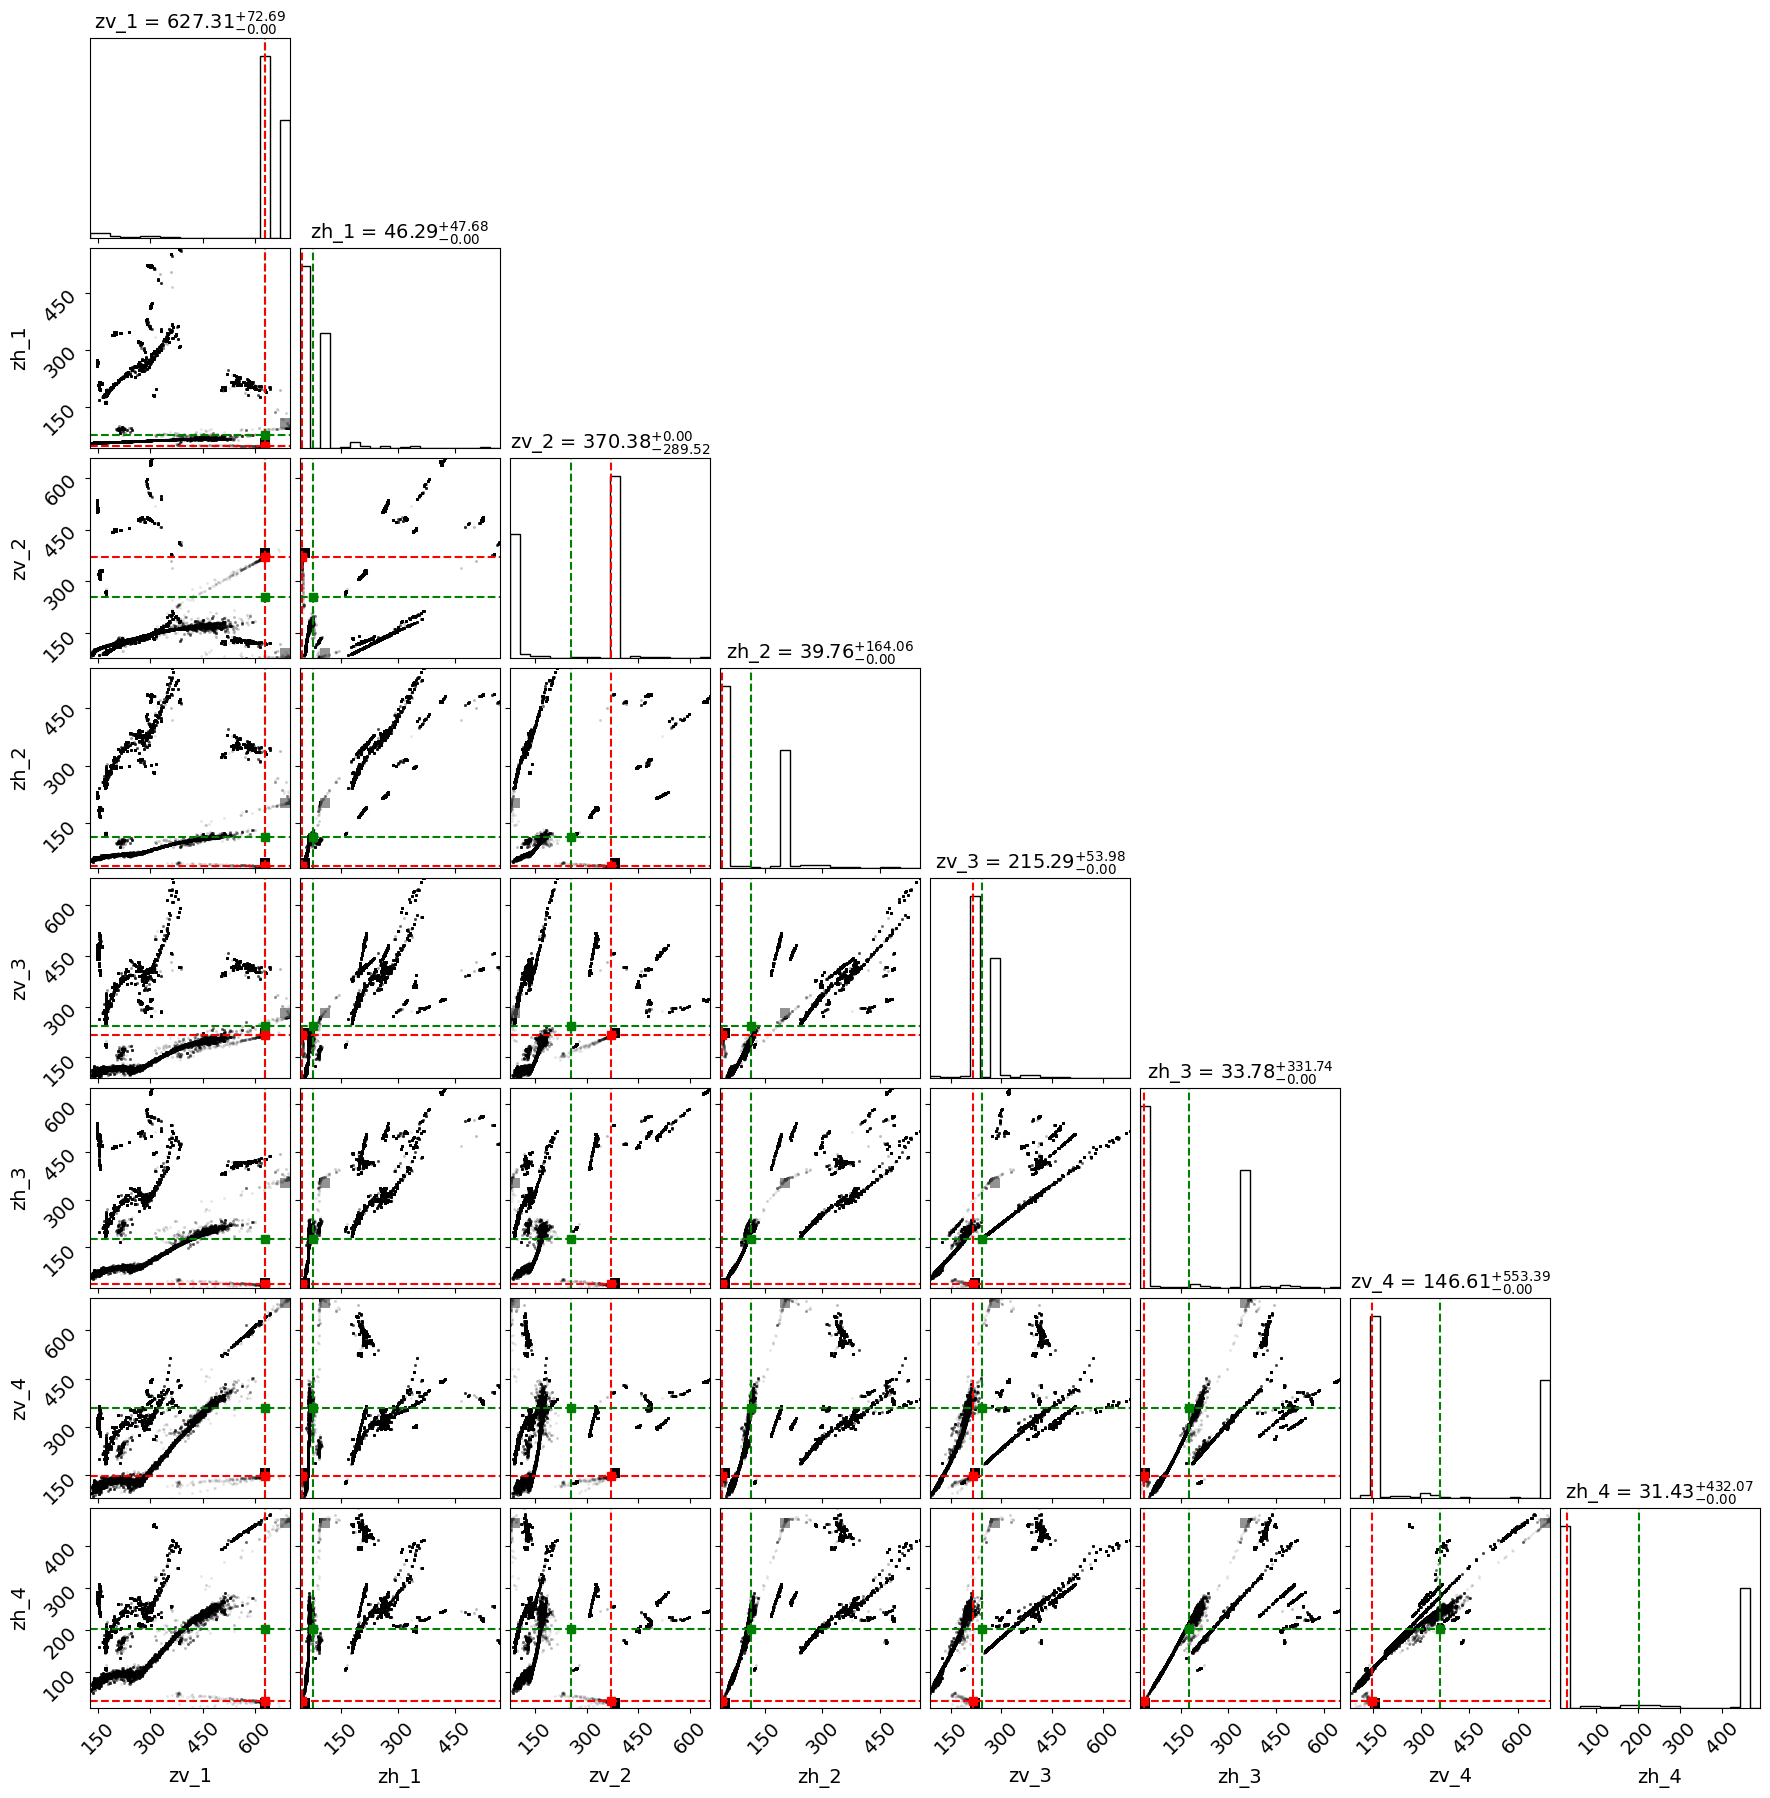

In [52]:
import matplotlib.pyplot as plt
import corner
import numpy as np
%matplotlib inline

plt.style.use('default')

# Set the font size
fs = 14
plt.rcParams.update({
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs           # Legend font size
})

# Create the corner plot
figure_corner = corner.corner(samples_flat, labels=symbols_list, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": fs})

# Access the axes in the corner plot
axes = figure_corner.axes

# Loop over the diagonal to add mean and MAP lines
for i in range(ndim):
    ax = axes[i * ndim + i]
    ax.axvline(mean_values[i], color="g", linestyle="--", label="Mean")
    ax.axvline(map_estimate[i], color="r", linestyle="--", label="MAP Estimate")

# Loop over the scatter plots (off-diagonal) to create filled contours
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi * ndim + xi]
        
        # Create filled contours using histogram2d
#         hist, xedges, yedges = np.histogram2d(samples[:, xi], samples[:, yi], bins=30)
#         X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
        
        # Use contourf for filled contours
        #ax.contourf(X, Y, hist.T, levels=15, cmap='viridis', alpha=0.8)  # Transpose hist for correct orientation

        # Add vertical and horizontal lines at the mean and MAP estimate
        ax.axvline(mean_values[xi], color="g", linestyle="--")
        ax.axvline(map_estimate[xi], color="r", linestyle="--")
        ax.axhline(mean_values[yi], color="g", linestyle="--")
        ax.axhline(map_estimate[yi], color="r", linestyle="--")

        # Plot points for mean and MAP estimate
        ax.plot(mean_values[xi], mean_values[yi], "sg")
        ax.plot(map_estimate[xi], map_estimate[yi], "sr")

# Optionally save the figure
# figure_corner.savefig(image_path_figure_corner, bbox_inches='tight', dpi=300)
plt.show()


#### w filter

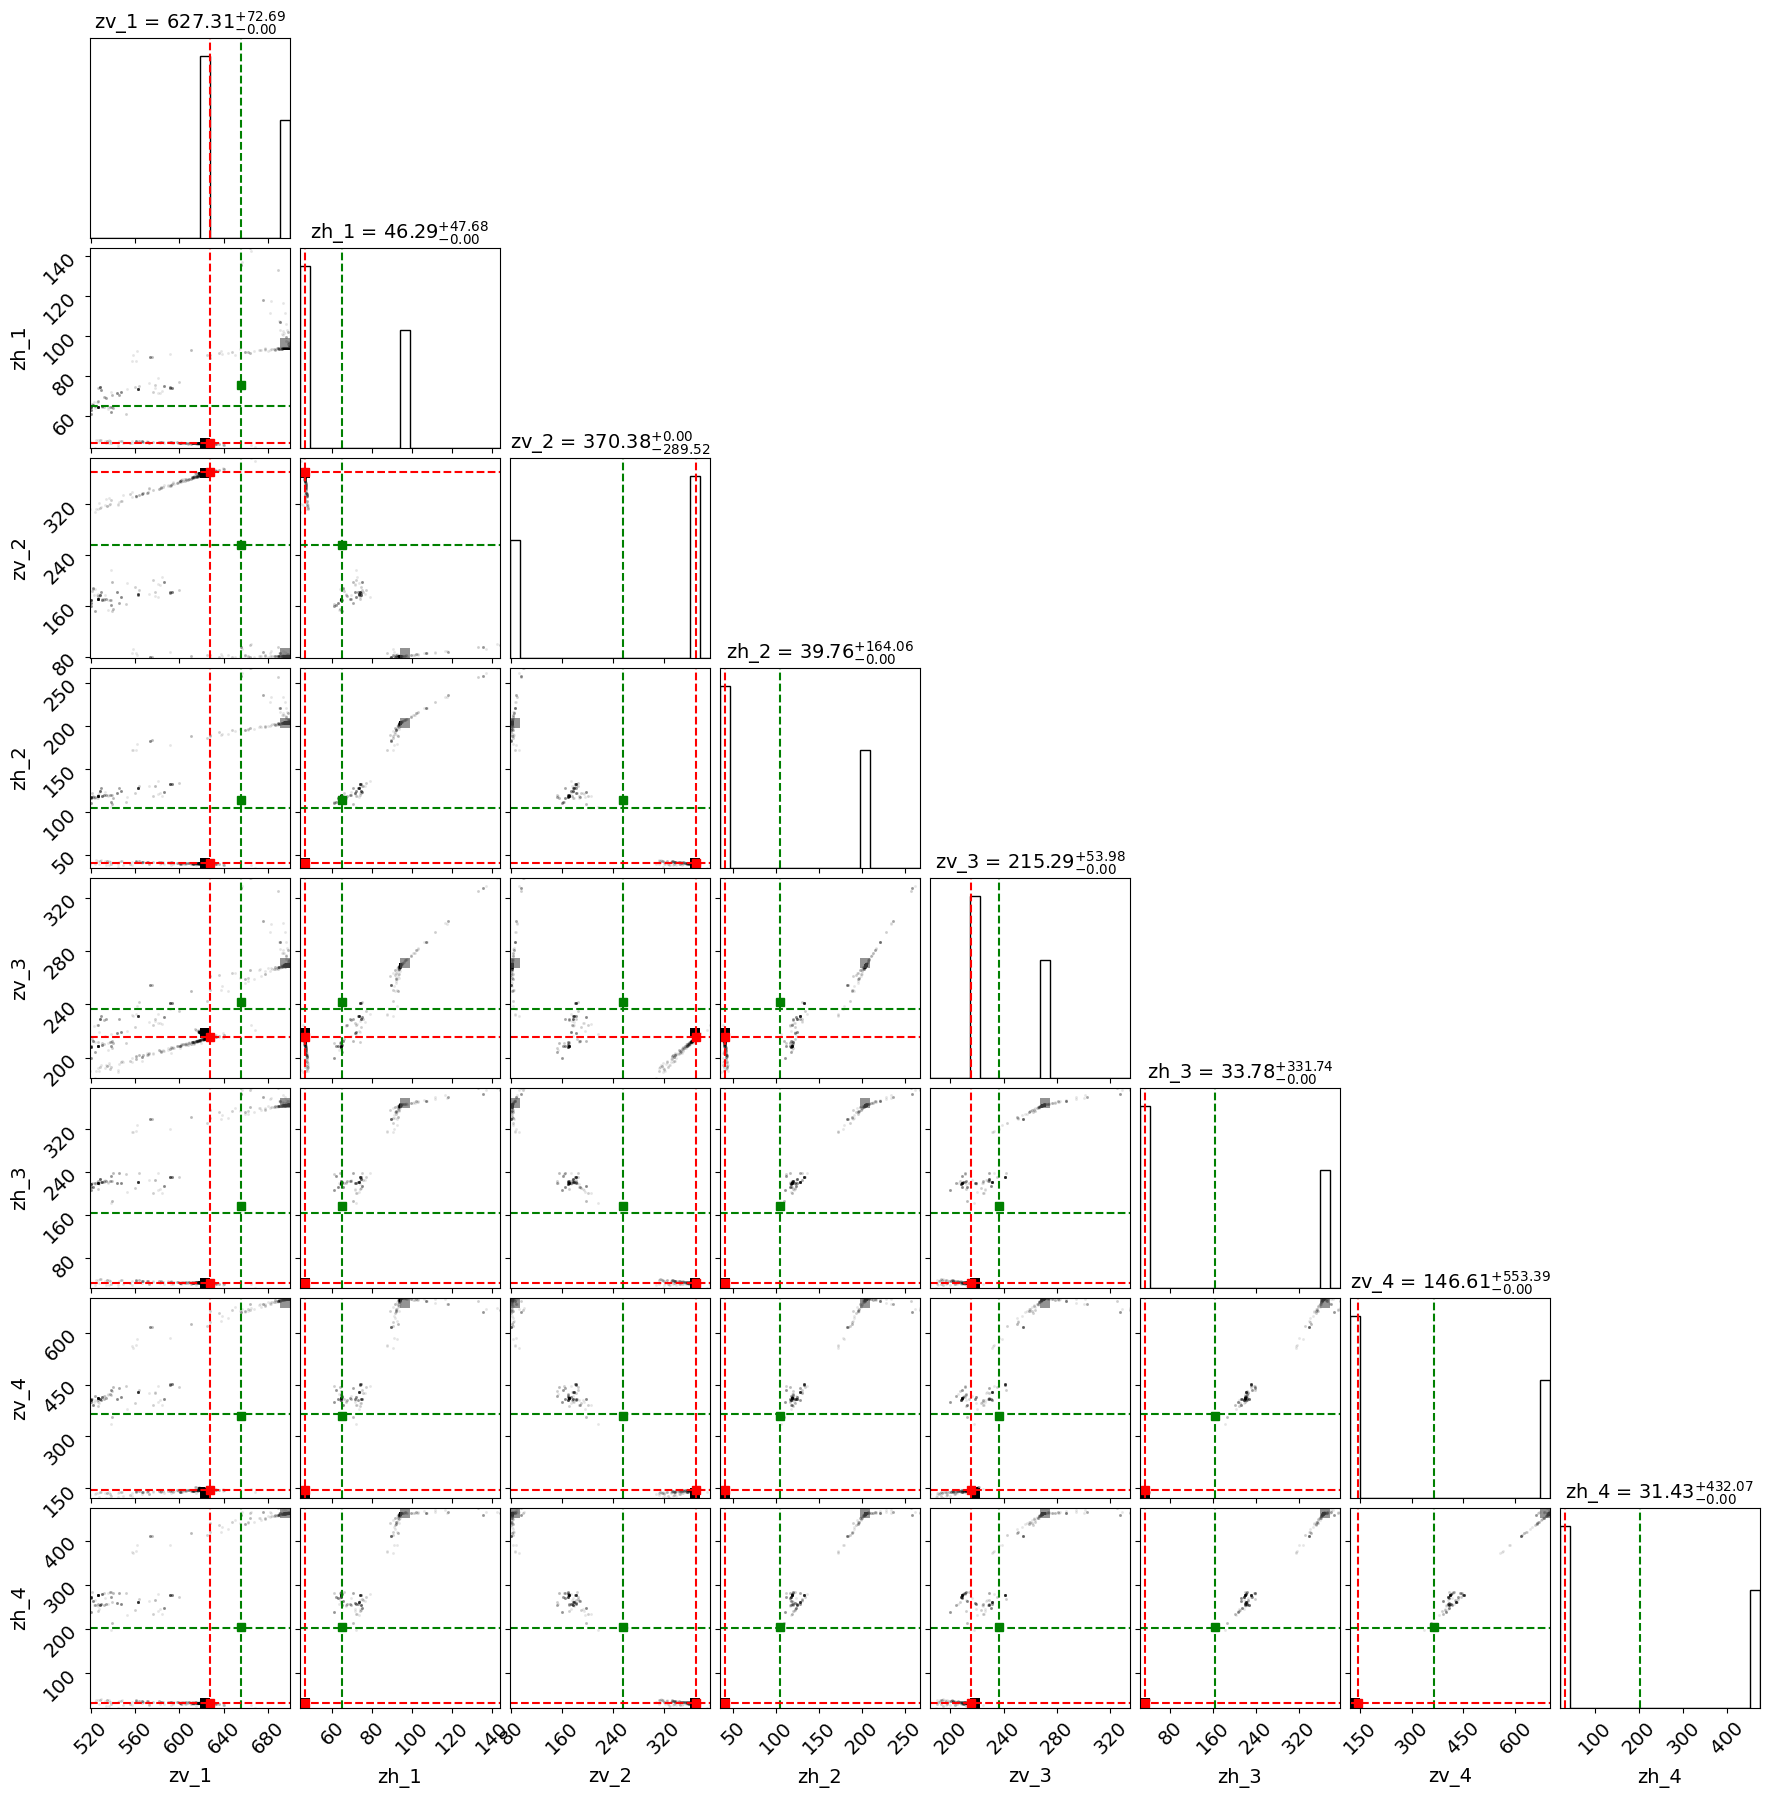

In [53]:
import matplotlib.pyplot as plt
import corner
import numpy as np
%matplotlib inline

plt.style.use('default')

# Set the font size
fs = 14
plt.rcParams.update({
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs           # Legend font size
})

# Create the corner plot
figure_corner = corner.corner(filtered_samples_flat, labels=symbols_list, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": fs})

# Access the axes in the corner plot
axes = figure_corner.axes

# Loop over the diagonal to add mean and MAP lines
for i in range(ndim):
    ax = axes[i * ndim + i]
    ax.axvline(mean_values_f[i], color="g", linestyle="--", label="Mean")
    ax.axvline(map_estimate_f[i], color="r", linestyle="--", label="MAP Estimate")

# Loop over the scatter plots (off-diagonal) to create filled contours
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi * ndim + xi]
        
        # Create filled contours using histogram2d
#         hist, xedges, yedges = np.histogram2d(filtered_samples_all[:, xi], filtered_samples_all[:, yi], bins=30)
#         X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
        
#         # Use contourf for filled contours
#         ax.contourf(X, Y, hist.T, levels=15, cmap='viridis', alpha=0.8)  # Transpose hist for correct orientation

        # Add vertical and horizontal lines at the mean and MAP estimate
        ax.axvline(mean_values_f[xi], color="g", linestyle="--")
        ax.axvline(map_estimate_f[xi], color="r", linestyle="--")
        ax.axhline(mean_values_f[yi], color="g", linestyle="--")
        ax.axhline(map_estimate_f[yi], color="r", linestyle="--")

        # Plot points for mean and MAP estimate
        ax.plot(mean_values_f[xi], mean_values[yi], "sg")
        ax.plot(map_estimate_f[xi], map_estimate[yi], "sr")

# Optionally save the figure
# figure_corner.savefig(image_path_figure_corner, bbox_inches='tight', dpi=300)
plt.show()

### S Plotter

#### Current design in tuning

Center: 25.00 GHz
Normal: 11.2 GHz - 38.8 GHz, BW: 27.6 GHz (1.104)
Diff: S21 - S31 (0.812) offset 1.98 dB
0.30257415771484375


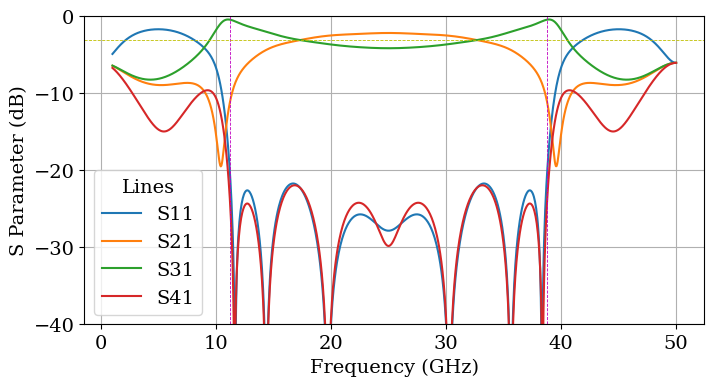

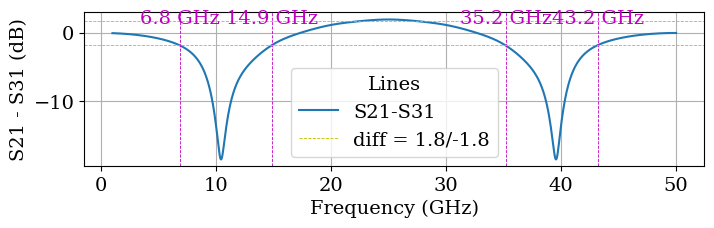

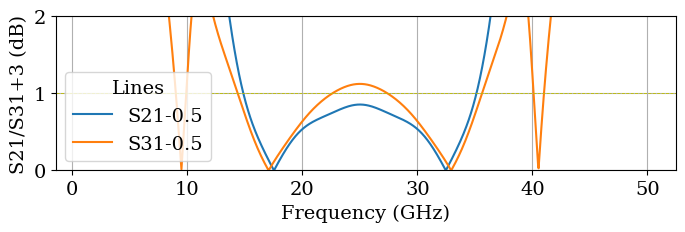

In [22]:
%matplotlib inline
plt.style.use('default')

# Set the font size
fs = 14
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs           # Legend font size
})

start = time.time() 
_ = qhdc_creater_plotter([478, 41.4, 288, 31.1, 141.77, 22.57, 74.9, 19.8])
end = time.time() 
print((end - start))

#### Reference untuned design

Center: 25.00 GHz
Normal: 11.2 GHz - 38.8 GHz, BW: 27.6 GHz (1.104)
Diff: S21 - S31 (0.812) offset 1.98 dB


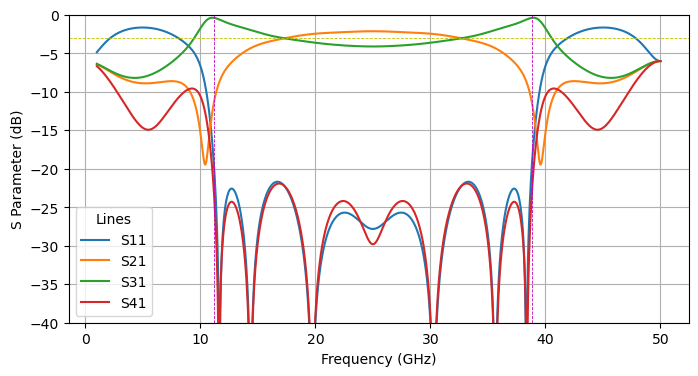

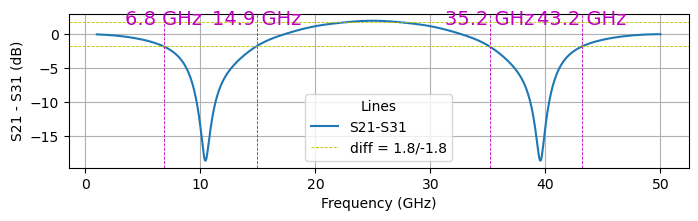

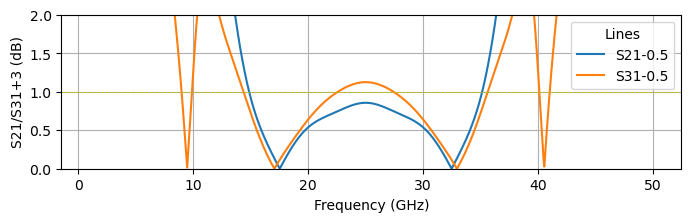

In [33]:
%matplotlib inline
_ = qhdc_creater_plotter([478, 41.4, 288, 31.1, 141.77, 22.57, 74.9, 19.8])

Center: 25.00 GHz
Normal: 38.4 GHz - 11.6 GHz, BW: 26.8 GHz (1.072)
Diff: S21 - S31 (0.677) offset 0.84 dB


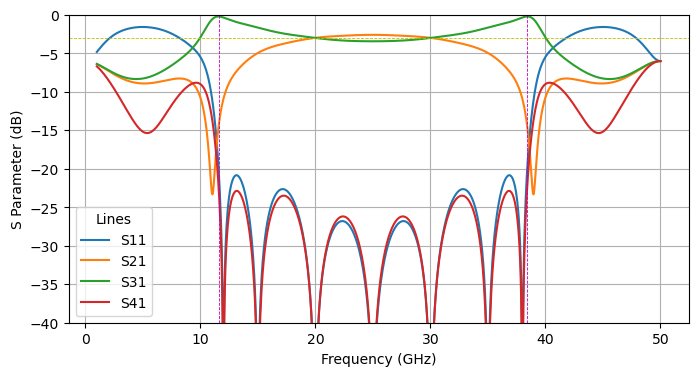

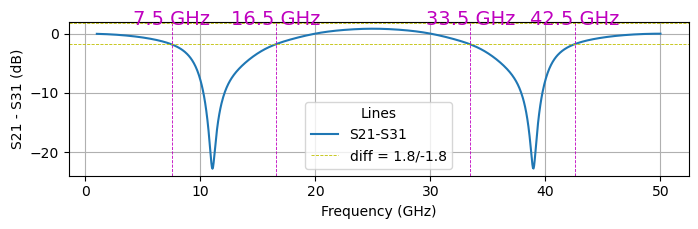

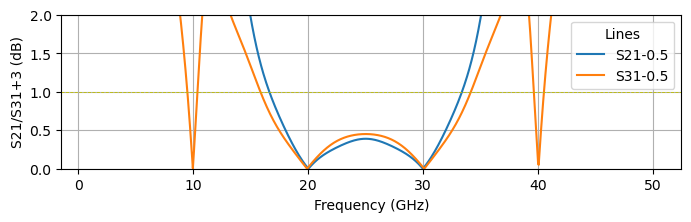

In [34]:
dump = qhdc_creater_plotter([453.0, 42.2, 263.0, 31.1, 124.2, 22.4, 69.5, 19.4])

#### Impedance tweaker

In [57]:
%matplotlib qt
from matplotlib.widgets import Slider, Button

def qhdc_eq_fetch(derived_imp):
    #input
    eps_r = 4.0
    f_res = 25 * pow(10, 9)  #GHz
    z_0 = 50
    z_line = z_0/math.sqrt(2)
    pi = math.pi
    
    s11_plot_dB_pre = []
    s21_plot_dB_pre = []
    s31_plot_dB_pre = []
    s41_plot_dB_pre = []

    for f_test in freq_Hz:
        s11_plot_dB_pre.append(get_s11eq(*np.append([f_test, 50], derived_imp)))
        s21_plot_dB_pre.append(get_s21eq(*np.append([f_test, 50], derived_imp)))
        s31_plot_dB_pre.append(get_s31eq(*np.append([f_test, 50], derived_imp)))
        s41_plot_dB_pre.append(get_s41eq(*np.append([f_test, 50], derived_imp)))

    s11_plot_dB = 20 * np.log10(np.abs(s11_plot_dB_pre))
    s21_plot_dB = 20 * np.log10(np.abs(s21_plot_dB_pre))
    s31_plot_dB = 20 * np.log10(np.abs(s31_plot_dB_pre))
    s41_plot_dB = 20 * np.log10(np.abs(s41_plot_dB_pre))
 
    return [s11_plot_dB, s21_plot_dB, s31_plot_dB, s41_plot_dB]
 
freq_Hz = np.linspace(1 * pow(10, 9), 50 * pow(10, 9), 1000)
# Convert frequency values from Hz to GHz
freq_GHz = freq_Hz / pow(10, 9)

# Get output
s11_variable, s21_variable, s31_variable, s41_variable = qhdc_eq_fetch(list(mean_values))
# Calculate the difference
s21_minus_s31 = s21_variable - s31_variable

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the first four S-parameters
line_s11, = ax1.plot(freq_GHz, s11_variable, label='S11')
line_s21, = ax1.plot(freq_GHz, s21_variable, label='S21')
line_s31, = ax1.plot(freq_GHz, s31_variable, label='S31')
line_s41, = ax1.plot(freq_GHz, s41_variable, label='S41')
#ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('S Parameter (dB)')
ax1.grid(True)
ax1.legend()

# Plot the difference in the second subplot
line_diff, = ax2.plot(freq_GHz, s21_minus_s31, label='S21 - S31', linestyle='--', color='orange')
ax2.axhline(y=-1.8, color='red', linestyle='--')
ax2.axhline(y=1.8, color='red', linestyle='--')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('S21-S31 (dB)')
ax2.grid(True)
ax2.legend()


# Create slider axes
axis = plt.axes([0.75, 0.75, 0.14, 0.05])
axis2 = plt.axes([0.75, 0.65, 0.14, 0.05])
axis3 = plt.axes([0.75, 0.55, 0.14, 0.05])
axis4 = plt.axes([0.75, 0.45, 0.14, 0.05])
axis5 = plt.axes([0.75, 0.35, 0.14, 0.05])
axis6 = plt.axes([0.75, 0.25, 0.14, 0.05])
axis7 = plt.axes([0.75, 0.15, 0.14, 0.05])
axis8 = plt.axes([0.75, 0.05, 0.14, 0.05])

# Create sliders
slider1 = Slider(axis, 'First', mean_values[0] - 25, mean_values[0] + 25, valinit=mean_values[0])
slider2 = Slider(axis2, "Second", mean_values[1] - 25, mean_values[1] + 25, valinit=mean_values[1])
slider3 = Slider(axis3, "Third", mean_values[2] - 25, mean_values[2] + 25, valinit=mean_values[2])
slider4 = Slider(axis4, "Fourth", mean_values[3] - 25, mean_values[3] + 25, valinit=mean_values[3])
slider5 = Slider(axis5, "Fifth", mean_values[4] - 25, mean_values[4] + 25, valinit=mean_values[4])
slider6 = Slider(axis6, "Sixth", mean_values[5] - 25, mean_values[5] + 25, valinit=mean_values[5])
slider7 = Slider(axis7, "Seventh", mean_values[6] - 25, mean_values[6] + 25, valinit=mean_values[6])
slider8 = Slider(axis8, "Eigth", mean_values[7] - 25, mean_values[7] + 25, valinit=mean_values[7])

# Create button axes for arrows (adjusted position to avoid overlap)
button_ax1_up = plt.axes([0.85, 0.75, 0.025, 0.025])
button_ax1_down = plt.axes([0.75, 0.75, 0.025, 0.025])

button_ax2_up = plt.axes([0.85, 0.65, 0.025, 0.025])
button_ax2_down = plt.axes([0.75, 0.65, 0.025, 0.025])

button_ax3_up = plt.axes([0.85, 0.55, 0.025, 0.025])
button_ax3_down = plt.axes([0.75, 0.55, 0.025, 0.025])

button_ax4_up = plt.axes([0.85, 0.45, 0.025, 0.025])
button_ax4_down = plt.axes([0.75, 0.45, 0.025, 0.025])

button_ax5_up = plt.axes([0.85, 0.35, 0.025, 0.025])
button_ax5_down = plt.axes([0.75, 0.35, 0.025, 0.025])

button_ax6_up = plt.axes([0.85, 0.25, 0.025, 0.025])
button_ax6_down = plt.axes([0.75, 0.25, 0.025, 0.025])

button_ax7_up = plt.axes([0.85, 0.15, 0.025, 0.025])
button_ax7_down = plt.axes([0.75, 0.15, 0.025, 0.025])

button_ax8_up = plt.axes([0.85, 0.05, 0.025, 0.025])
button_ax8_down = plt.axes([0.75, 0.05, 0.025, 0.025])

# Create buttons
button1_up = Button(button_ax1_up, '^', color='lightgoldenrodyellow')
button1_down = Button(button_ax1_down, 'v', color='lightgoldenrodyellow')
button2_up = Button(button_ax2_up, '^', color='lightgoldenrodyellow')
button2_down = Button(button_ax2_down, 'v', color='lightgoldenrodyellow')
button3_up = Button(button_ax3_up, '^', color='lightgoldenrodyellow')
button3_down = Button(button_ax3_down, 'v', color='lightgoldenrodyellow')
button4_up = Button(button_ax4_up, '^', color='lightgoldenrodyellow')
button4_down = Button(button_ax4_down, 'v', color='lightgoldenrodyellow')
button5_up = Button(button_ax5_up, '^', color='lightgoldenrodyellow')
button5_down = Button(button_ax5_down, 'v', color='lightgoldenrodyellow')
button6_up = Button(button_ax6_up, '^', color='lightgoldenrodyellow')
button6_down = Button(button_ax6_down, 'v', color='lightgoldenrodyellow')
button7_up = Button(button_ax7_up, '^', color='lightgoldenrodyellow')
button7_down = Button(button_ax7_down, 'v', color='lightgoldenrodyellow')
button8_up = Button(button_ax8_up, '^', color='lightgoldenrodyellow')
button8_down = Button(button_ax8_down, 'v', color='lightgoldenrodyellow')


# Initialize a list to keep track of the frequency label text objects
label_texts = []

def update(val):
    # Clear previous labels
    for label in label_texts:
        label.remove()
    label_texts.clear()  # Clear the list

    new_mean_values = [
        slider1.val,
        slider2.val,
        slider3.val,
        slider4.val,
        slider5.val,
        slider6.val,
        slider7.val,
        slider8.val
    ]
    
    # Get updated output based on new mean values
    s11_variable, s21_variable, s31_variable, s41_variable = qhdc_eq_fetch(new_mean_values)
    
    # Update the plot lines for S-parameters
    line_s11.set_ydata(s11_variable)
    line_s21.set_ydata(s21_variable)
    line_s31.set_ydata(s31_variable)
    line_s41.set_ydata(s41_variable)
    
    # Calculate the difference and update the second plot
    s21_minus_s31 = s21_variable - s31_variable
    line_diff.set_ydata(s21_minus_s31)
    peak_index = np.argmax(s21_minus_s31)

    # Find the crossing indices again
    crossing_indices = []
    for i in range(1, len(s21_minus_s31)):
        if (s21_minus_s31[i - 1] < -1.8 <= s21_minus_s31[i]) or (s21_minus_s31[i - 1] >= -1.8 > s21_minus_s31[i]):
            crossing_indices.append(i)

    exact_crossing_indices = [i for i, value in enumerate(s21_minus_s31) if value == -1.8]
    crossing_indices.extend(exact_crossing_indices)
    crossing_indices = sorted(set(crossing_indices))  # Remove duplicates and sort

    # Plot vertical lines and labels at crossing points
    for index in crossing_indices:
        #ax2.axvline(x=freq_GHz[index], color='m', linestyle='--', linewidth=0.6)
        label = ax2.text(freq_GHz[index], 0.8, f'{freq_GHz[index]:.1f} GHz', color='m', fontsize=14, ha='center', va='bottom')
        label_texts.append(label)  # Keep track of the label

    # Calculate frequency differences if there are enough crossing points
    temp_freq_list = sorted([freq_GHz[i] for i in crossing_indices])
    if len(temp_freq_list) > 2:
        diff_bw_s21_s31 = round((temp_freq_list[2] - temp_freq_list[1]) / (f_res / 1e9), 3)
        ax2.set_title(f'Diff: S21 - S31 ({diff_bw_s21_s31}) offset {round(s21_minus_s31[peak_index], 2)} dB')

    # Redraw the figures
    fig.canvas.draw_idle()

# Attach the update function to the sliders
slider1.on_changed(update)
slider2.on_changed(update)
slider3.on_changed(update)
slider4.on_changed(update)
slider5.on_changed(update)
slider6.on_changed(update)
slider7.on_changed(update)
slider8.on_changed(update)

# Button functions for sliders
def adjust_slider(slider, delta):
    slider.set_val(slider.val + delta)
    update(None)

least_count = 0.2
button1_up.on_clicked(lambda event: adjust_slider(slider1, least_count))
button1_down.on_clicked(lambda event: adjust_slider(slider1, -least_count))
button2_up.on_clicked(lambda event: adjust_slider(slider2, least_count))
button2_down.on_clicked(lambda event: adjust_slider(slider2, -least_count))
button3_up.on_clicked(lambda event: adjust_slider(slider3, least_count))
button3_down.on_clicked(lambda event: adjust_slider(slider3, -least_count))
button4_up.on_clicked(lambda event: adjust_slider(slider4, least_count))
button4_down.on_clicked(lambda event: adjust_slider(slider4, -least_count))
button5_up.on_clicked(lambda event: adjust_slider(slider5, least_count))
button5_down.on_clicked(lambda event: adjust_slider(slider5, -least_count))
button6_up.on_clicked(lambda event: adjust_slider(slider6, least_count))
button6_down.on_clicked(lambda event: adjust_slider(slider6, -least_count))
button7_up.on_clicked(lambda event: adjust_slider(slider7, least_count))
button7_down.on_clicked(lambda event: adjust_slider(slider7, -least_count))
button8_up.on_clicked(lambda event: adjust_slider(slider8, least_count))
button8_down.on_clicked(lambda event: adjust_slider(slider8, -least_count))

# Create button axes for the reset button
reset_button_ax = plt.axes([0.05, 0.05, 0.14, 0.05])  # Adjust position as needed
reset_button = Button(reset_button_ax, 'Reset', color='lightgoldenrodyellow')

# Define the reset function
def reset(event):
    slider1.set_val(mean_values[0])
    slider2.set_val(mean_values[1])
    slider3.set_val(mean_values[2])
    slider4.set_val(mean_values[3])
    slider5.set_val(mean_values[4])
    slider6.set_val(mean_values[5])
    slider7.set_val(mean_values[6])
    slider8.set_val(mean_values[7])
    update(None)  # Call update to refresh the plot with the reset values

# Connect the reset button to the reset function
reset_button.on_clicked(reset)

plt.show()

## MCMC Convegence tests and statistical analysis

### Bayesian Inference Analysis

In [157]:
idata1 = az.from_emcee(sampler, var_names=symbols_list)
idata1.sel(draw=slice(burn_in, None))

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Mean and HPD of stationary post distribution

array([[<Axes: title={'center': 'zv_1'}>,
        <Axes: title={'center': 'zh_1'}>,
        <Axes: title={'center': 'zv_2'}>,
        <Axes: title={'center': 'zh_2'}>],
       [<Axes: title={'center': 'zv_3'}>,
        <Axes: title={'center': 'zh_3'}>,
        <Axes: title={'center': 'zv_4'}>,
        <Axes: title={'center': 'zh_4'}>]], dtype=object)

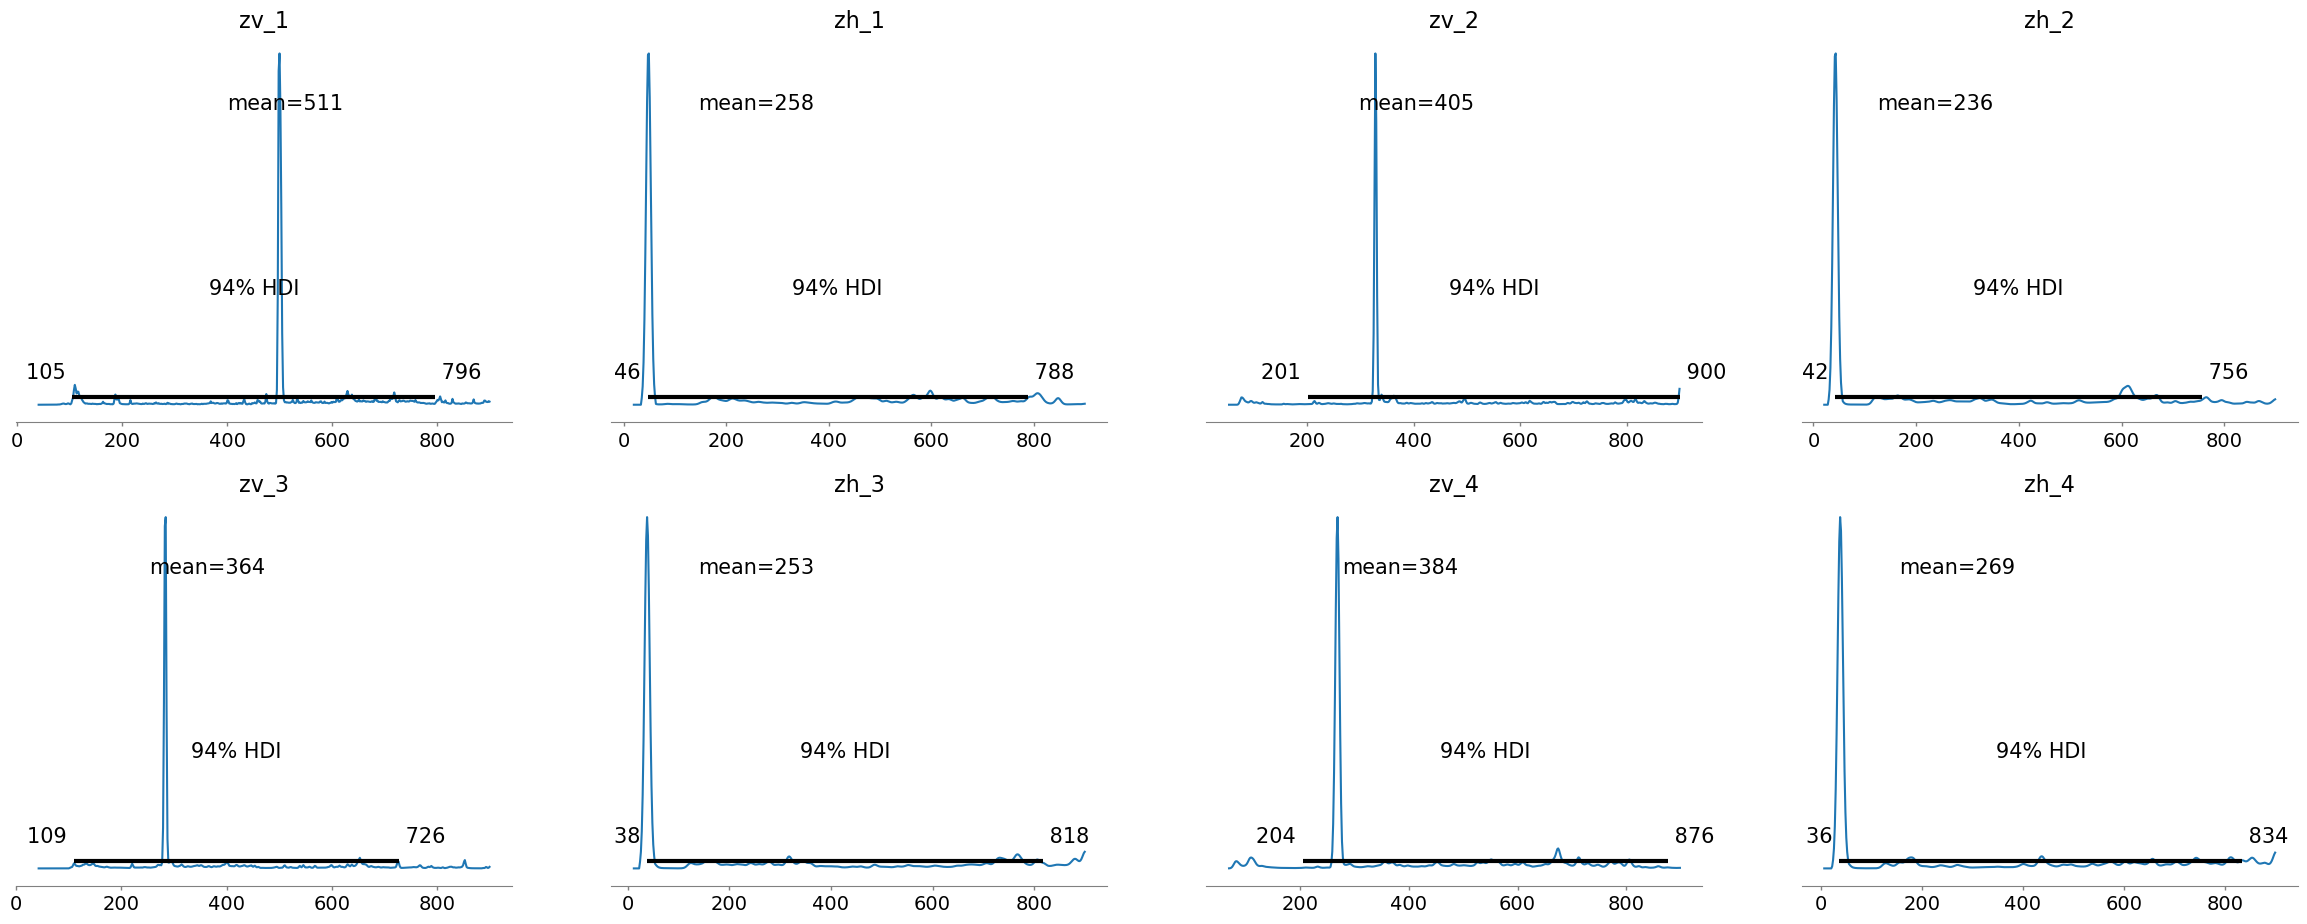

In [158]:
%matplotlib inline

plt.style.use('default')
az.plot_posterior(idata1, var_names=symbols_list)

In [159]:
summary = az.summary(idata1)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
zv_1,510.735,163.842,105.111,796.268,5.559,4.010,836.0,831.0,1.60
zh_1,257.769,277.451,46.492,787.925,10.989,7.774,673.0,917.0,2.01
zv_2,404.607,182.406,201.074,900.000,7.202,5.237,776.0,665.0,1.78
zh_2,236.388,268.682,41.614,755.914,10.915,7.765,625.0,582.0,2.27
zv_3,363.523,172.279,109.277,726.469,6.495,4.709,786.0,710.0,1.78
zh_3,252.977,297.299,37.909,817.727,12.063,8.559,623.0,761.0,2.29
zv_4,383.747,194.039,204.392,876.321,7.798,5.627,716.0,779.0,1.95
zh_4,269.431,307.597,36.492,833.507,12.197,8.628,647.0,889.0,2.13


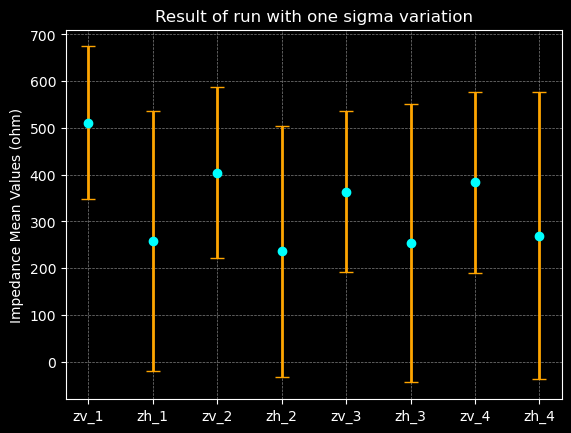

In [160]:
%matplotlib inline
symbols_str = [str(symbol) for symbol in symbols_list]

plt.style.use('dark_background')
# Create the plot
fig, ax = plt.subplots()

# Error bar plot with customized aesthetics
ax.errorbar(symbols_str, 
             np.array(list(summary['mean'])),
             yerr=np.array(list(summary['sd'])), 
             fmt='o', 
             color='cyan',  # Marker color
             ecolor='orange',  # Error bar color
             elinewidth=2,  # Thickness of error bars
             capsize=5)  # Size of error bar caps

ax.set_ylabel('Impedance Mean Values (ohm)')
ax.set_title('Result of run with one sigma variation')

# Customize the grid
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

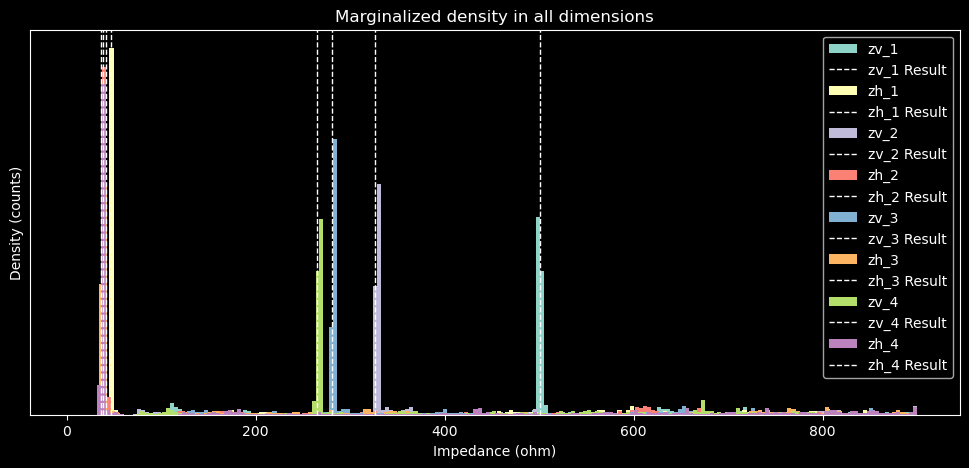

In [161]:
%matplotlib inline

plt.style.use('dark_background')
plt.figure(figsize=(12, 5))  
for i in range(8):
    chain = sampler.get_chain()[:, :, i].T
    
    plt.hist(chain.flatten(), bins=200, label = str(symbols_list[i]))
    plt.gca().set_yticks([])
    plt.axvline(x = map_estimate[i],linestyle='--', linewidth=1, label = f'{symbols_list[i]} Result')
    plt.xlabel("Impedance (ohm)")
    plt.ylabel(f"Density (counts)");
    plt.title('Marginalized density in all dimensions')
    #plt.xlim(170,180)
    plt.legend()

### Autocorrelation time estimates

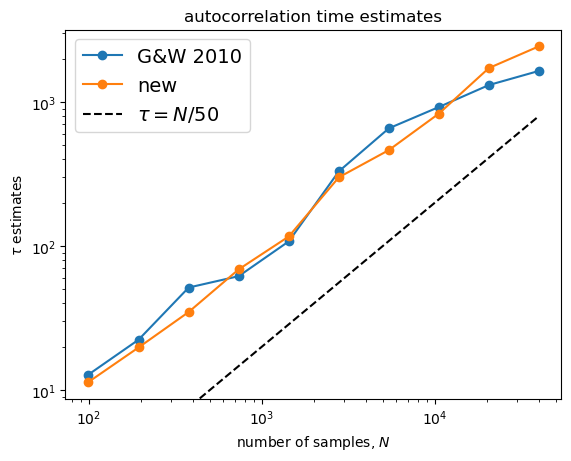

In [101]:
%matplotlib inline

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# ===========================================

plt.style.use('default')
chain = sampler.get_chain()[:, :, 0].T

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14)

# Finding the intersection between G&W 2010 and the reference line
difference = gw2010 - (N / 50.0)
indices = np.where(np.diff(np.sign(difference)))[0]

if len(indices) > 0:
    # Interpolation to find a more precise intersection point
    idx = indices[0]  # Take the first intersection
    n_intersect = (N[idx] + N[idx + 1]) / 2  # Average the N values around the intersection
    plt.axvline(n_intersect, color='orange', linestyle='--', label=f'{n_intersect} steps')
plt.title('autocorrelation time estimates')
plt.legend(fontsize=14)
plt.show()


## Run info

#### Run parameters

In [733]:
print('guess: ' + str(guess))
print('y: ' + str(y))
print('yerr: ' + str(yerr))
print('freq_solve: ' + str(freq_solve))
print('ndim: ' + str(ndim))
print('nwalkers: ' + str(nwalkers))
print('nsteps: ' + str(nsteps))
print('pert: ' + str(pert))

guess: [1000, 49, 1000, 49, 1000, 49, 650, 49, 650, 49]
y: [1.00000000e-06 7.07106781e-01 7.07106781e-01 1.00000000e-06]
yerr: [[1.00000000e-11 1.00000000e-09 1.00000000e-09 1.00000000e-09
  1.00000000e-09 1.00000000e-09 1.00000000e-09 1.00000000e-09
  1.00000000e-11]
 [7.07106781e-05 7.07106781e-05 7.07106781e-07 7.07106781e-07
  7.07106781e-07 7.07106781e-07 7.07106781e-07 7.07106781e-05
  7.07106781e-05]
 [7.07106781e-05 7.07106781e-05 7.07106781e-07 7.07106781e-07
  7.07106781e-07 7.07106781e-07 7.07106781e-07 7.07106781e-05
  7.07106781e-05]
 [1.00000000e-11 1.00000000e-09 1.00000000e-09 1.00000000e-09
  1.00000000e-09 1.00000000e-09 1.00000000e-09 1.00000000e-09
  1.00000000e-11]]
freq_solve: [9000000000.0, 12000000000.0, 15000000000.0, 20000000000.0, 25000000000.0, 30000000000.0, 35000000000.0, 38000000000.0, 41000000000.0]
ndim: 10
nwalkers: 750
nsteps: 50000
pert: 0.1


#### Results

In [734]:
print('map_estimate: ' + str(np.round((map_estimate), 4)))
print('Actual Value: ' + str(np.round(actual_values, 4)))

print('\n')
print("Mean values:", mean_values)
print("Median values:", median_values)   
print("Standard deviations:", std_devs)

map_estimate: [541.9863  46.4651 694.4024  42.2426 353.0463  37.3675 274.0306  33.8428
 261.1416  32.6116]
Actual Value: [1000   49 1000   49 1000   49  650   49  650   49]


Mean values: [719.32975755  47.60859417 769.00574695  44.58659378 431.428073
  40.98515719 344.87796631  38.29005664 329.2420872   37.32820291]
Median values: [688.15840411  47.57884447 751.31520187  44.49095985 419.65005524
  40.80380794 334.99233699  38.03522679 319.99034189  37.04513156]
Standard deviations: [134.29524091   0.69294837  63.10270022   1.46728713  58.15386137
   2.30561728  52.03036144   2.87377304  50.07326857   3.06423296]


# Save samples

In [114]:
# Assuming `samples` is your array of samples
samples = sampler.get_chain(discard=0, thin=1)
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# Save the samples to a file
np.save(f"del_run{now}_thin{thin}_discard{burn_in}_{len(freq_solve)}_w{nwalkers}_s{nsteps}.npy", samples)

# Read saved files

In [115]:
samples_read = np.load(f"del_run{now}_thin{thin}_discard{burn_in}_{len(freq_solve)}_w{nwalkers}_s{nsteps}.npy")

samples_after_burn_in = samples_read[burn_in:]
samples_thinned = samples_after_burn_in[::thin]
# Reshape the array to (n_samples, n_walkers * n_dim)
n_samples, n_walkers, n_dim = samples_thinned.shape
samples_flat = samples_thinned.reshape(n_samples * n_walkers, n_dim)

In [116]:
# Calculate the mean of the postemean_values distributions
mean_values = np.mean(samples_flat, axis=0)
print("Mean values:", mean_values)

# Calculate the median of the posterior distributions
median_values = np.median(samples_flat, axis=0)
print("Median values:", median_values)

# Calculate the standard deviation of the posterior distributions
std_devs = np.std(samples_flat, axis=0)
print("Standard deviations:", std_devs)

Mean values: [230.06480071  40.56041243  68.46456895  33.14411446]
Median values: [228.03321064  40.57109252  67.54655093  33.123873  ]
Standard deviations: [18.30820911  1.44517817 10.20671811  2.36107583]


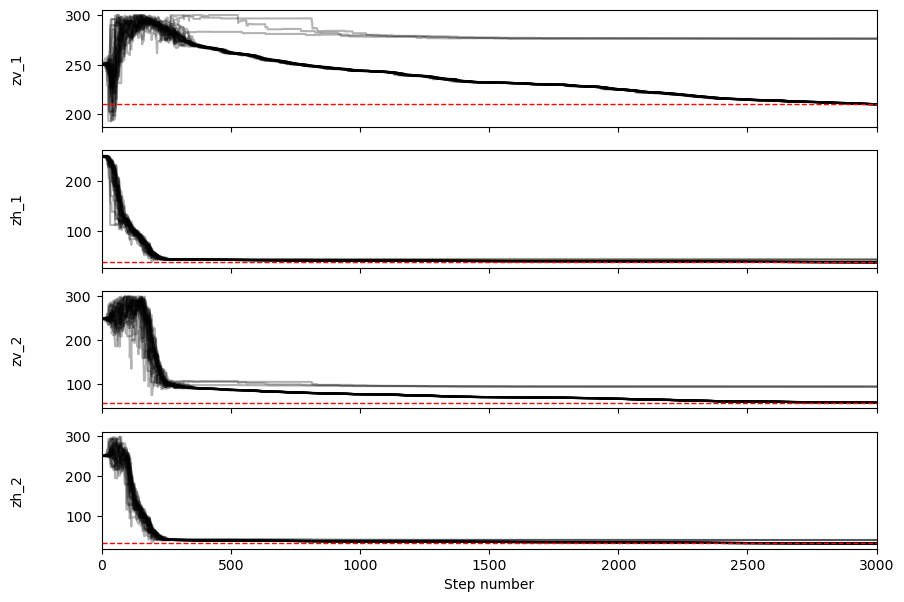

In [150]:
fig_samples_all, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = symbols_list

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_read))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.axhline(y=actual_values[i], color='g', linestyle='-', linewidth=1)
    ax.axhline(y=map_estimate[i], color='r', linestyle='--', linewidth=1)

axes[-1].set_xlabel("Step number")
plt.show()
        
# Define the image path in the current directory
image_path_fig_samples_all = os.path.join(os.getcwd(), "fig_samples_all.pdf")
fig_samples_all.savefig(image_path_fig_samples_all, bbox_inches='tight', dpi=300)

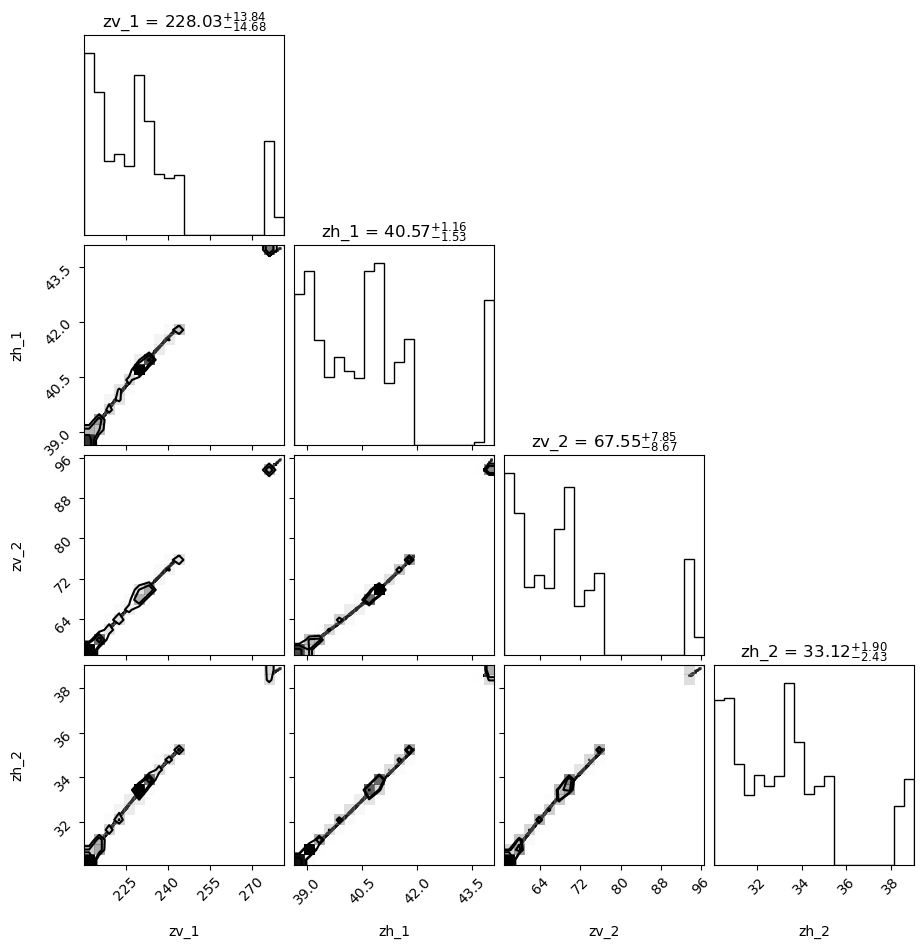

In [149]:
figure_corner = corner.corner(samples_flat, labels=symbols_list, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 12})

# Define the image path in the current directory
image_path_figure_corner = os.path.join(os.getcwd(), "figure_corner.pdf")
figure_corner.savefig(image_path_figure_corner, bbox_inches='tight', dpi=300)



#### MCMC Impedance S plot

Center: 25.00 GHz


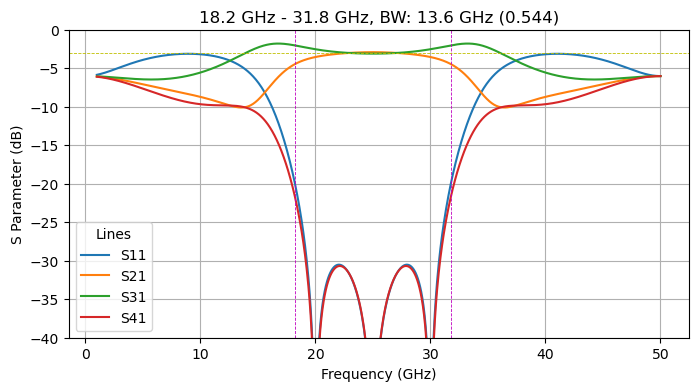

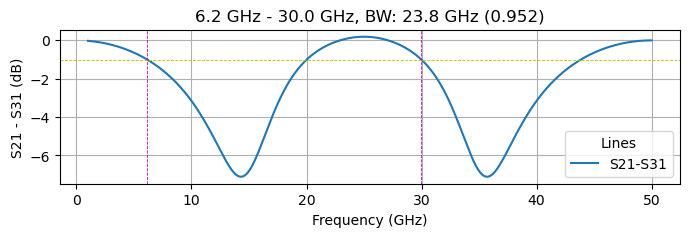

In [148]:
figure_mcmc_splot, figure_mcmc_bw_finder = qhdc_creater_plotter(list(map_estimate))

# Define the image path in the current directory
current_directory = os.getcwd()
image_path_figure_mcmc_splot = os.path.join(current_directory, "figure_mcmc_splot.pdf")
figure_mcmc_splot.savefig(image_path_figure_mcmc_splot, bbox_inches='tight', dpi=300)

image_path_figure_bw_finder = os.path.join(current_directory, "figure_mcmc_bw_finder.pdf")
figure_mcmc_bw_finder.savefig(image_path_figure_bw_finder, bbox_inches='tight', dpi=300)

In [120]:
def scientific_notation_round(arr, decimals):
    # Extract the significant part
    significant_part = arr / (10 ** np.floor(np.log10(arr)))
    # Round the significant part
    rounded_significant_part = np.round(significant_part, decimals)
    # Reconstruct the array
    result = rounded_significant_part * (10 ** np.floor(np.log10(arr)))
    return result

#### Generate report

In [151]:
# Helper function to convert arrays to vertical strings
def array_to_vertical_string(arr):
    return '\n'.join(map(str, arr))

# Helper function to convert lists to comma-separated strings
def list_to_string(lst):
    return ', '.join(f"{x:.1f}" for x in lst)

try:
    # Define the table data with formatted values
    data = [    
        ['Parameter', 'Value'],
        ['RUN PARAMETERS'],
        ['Guess given', str(guess)],
        ['Boundary values', array_to_vertical_string(y)],
        ['Boundary value error', array_to_vertical_string(scientific_notation_round(yerr, 2))],
        ['Freq solve points (GHz)', str([int(round(x / 1000000000)) for x in freq_solve])],
        ['No. of variables', str(ndim)],
        ['No. of walkers', str(nwalkers)],
        ['No. of steps', str(nsteps)],
        ['Perturbation', str(pert)],
        ['Cores used', str(noofcores)],
        ['Correct Value', str('...')],
        ['RESULTS OF RUN'],
        ['Burn in', str(burn_in)],
        ['Thin', str(thin)],
        ['Mean values', list_to_string(mean_values)],
        ['Median values', list_to_string(median_values)],
        ['Standard deviations', list_to_string(std_devs)],
        ['MAP Estimate', list_to_string(map_estimate)]
    ]
    
except:
    # Define the table data with formatted values
    data = [    
        ['Parameter', 'Value'],
        ['RUN PARAMETERS'],
        ['Guess given', str(guess)],
        ['Boundary values', array_to_vertical_string(y)],
        ['Boundary value error', array_to_vertical_string(scientific_notation_round(yerr, 2))],
        ['Freq solve points (GHz)', str([int(round(x / 1000000000)) for x in freq_solve])],
        ['No. of variables', str(ndim)],
        ['No. of walkers', str(nwalkers)],
        ['No. of steps', str(nsteps)],
        ['Perturbation', str(pert)],
        ['Cores used', str(noofcores)],
        ['Correct Value', str('...')], #list_to_string(actual_values)
        ['RESULTS OF RUN'],
        ['Burn in', str(burn_in)],
        ['Thin', str(thin)],
        ['Mean values', list_to_string(mean_values)],
        ['Median values', list_to_string(median_values)],
        ['Standard deviations', list_to_string(std_devs)]
    ]
# Create the table and add styles
table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),  # Header row
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, 0), 'CENTER'),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),  # Default cell background
    ('ALIGN', (0, 1), (-1, -1), 'LEFT'),
    ('VALIGN', (0, 1), (-1, -1), 'TOP'),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('FONT', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONT', (0, 1), (-1, -1), 'Helvetica'),

    # Style for 'RUN PARAMETERS' section heading
    ('BACKGROUND', (0, 1), (1, 1), colors.lightblue),
    ('FONT', (0, 1), (1, 1), 'Helvetica-Bold'),
    ('ALIGN', (0, 1), (1, 1), 'CENTER'),

    # Style for 'RESULTS OF RUN' section heading
    ('BACKGROUND', (0, 12), (1, 12), colors.lightgreen),
    ('FONT', (0, 12), (1, 12), 'Helvetica-Bold'),
    ('ALIGN', (0, 12), (1, 12), 'CENTER'),
]))

# Create a PDF file with A4 page size
table_pdf_path = "test.pdf"

# Check if the file exists and delete it if it does
if os.path.exists(table_pdf_path):
    os.remove(table_pdf_path)
    print(f"{table_pdf_path} already existed and has been deleted.")
else:
    print(f"{table_pdf_path} does not exist, so it will be created.")
    
    

# Create the PDF document template for the table
doc = SimpleDocTemplate(table_pdf_path, pagesize=A4)
# Define the styles for the document
styles = getSampleStyleSheet()
heading_style = styles['Title']
paragraph_style = styles['Normal']

# Generate current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
heading = Paragraph(f"<b>Date and Time: {current_datetime}</b>", heading_style)

# Create a paragraph block text
user_paragraph_text = input("Enter the paragraph text for the document: ")
paragraph = Paragraph(user_paragraph_text, paragraph_style)
# Create a paragraph block with user input text
paragraph = Paragraph(user_paragraph_text, paragraph_style)

# Define styles for the document
elements = [Spacer(1, 0.5*inch), heading, Spacer(1, 0.5*inch), paragraph, Spacer(1, 0.5*inch), table]
doc.build(elements)

# Define paths for images
image_paths = {
    "Parameter space exploration Plot": image_path_fig_samples_all,
    "Corner Plot": image_path_figure_corner,
    "MCMC S Plot": image_path_figure_mcmc_splot,
    "S31_S21 differential plot": image_path_figure_bw_finder
}

# Define the path for the final combined PDF
combined_pdf_path = f"{current_datetime}_w{nwalkers}_s{nsteps}_{len(freq_solve)}.pdf"

# Create a PDF merger object
pdf_merger = PyPDF2.PdfMerger()

# Add the table PDF to the merger
pdf_merger.append(table_pdf_path)

# Add the image PDFs to the merger
for title, image_path in image_paths.items():
    if os.path.exists(image_path):
        pdf_merger.append(image_path)
    else:
        print(f"{image_path} does not exist and will not be added to the combined PDF.")

# Write out the combined PDF
pdf_merger.write(combined_pdf_path)
pdf_merger.close()

print(f"Combined PDF created successfully at {combined_pdf_path}!")

# Clean up: remove the intermediate PDF files
if os.path.exists(table_pdf_path):
    os.remove(table_pdf_path)
    print(f"{table_pdf_path} has been deleted.")

for image_path in image_paths.values():
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"{image_path} has been deleted.")

test.pdf does not exist, so it will be created.


Enter the paragraph text for the document:  will go to faroe islands one day!!


Combined PDF created successfully at 2024-09-07_15-34-04_w30_s3000_3.pdf!
test.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/fig_samples_all.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/figure_corner.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/figure_mcmc_splot.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/figure_mcmc_bw_finder.pdf has been deleted.


In [154]:
def temp(a,b):
    test = s + str(x)    
    return exec(test)

a = temp(1,0)
a

 + (2*b


' + (2*b'

In [147]:
print(a)

None


In [136]:
prog = 'print("The sum of 5 and 10 is", (5+10))'
exec(prog)


The sum of 5 and 10 is 15


In [169]:
s = '@jit(nopython=True, cache=True)\ndef get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2):\n    I = 1j\n    return'
x = np.load('numpy_strings/a_e.npy', allow_pickle=True)    
test1 = (f'{s} {x}')

In [170]:
exec(test1)

RuntimeError: cannot cache function 'get_a_o_eq': no locator available for file '<string>'

In [158]:
print(s)

@jit(nopython=True, cache=True)
def get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return
